# Research Question 1: Is there a causal relationship between air quality and future socioeconomic outcomes?

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

### Load datasets

In [11]:
ca_air_quality = pd.read_csv('ca_air_quality.csv')
ca_covariates = pd.read_csv('ca_covariates.csv')
ca_trends = pd.read_csv('ca_trends.csv')

### Explore Air Quality dataset

In [12]:
ca_trends.columns

Index(['county_name', 'kfr_p1', 'kfr_p25', 'kfr_p50', 'kfr_p75', 'kfr_p100',
       'kir_p1', 'kir_p25', 'kir_p50', 'kir_p75', 'kir_p100', 'emp_p1',
       'emp_p25', 'emp_p50', 'emp_p75', 'emp_p100', 'kfi_p1', 'kii_p1',
       'kfi_p25', 'kii_p25', 'kfi_p50', 'kii_p50', 'kfi_p75', 'kii_p75',
       'kfi_p100', 'kii_p100'],
      dtype='object')

In [13]:
ca_air_quality['county'] = ca_air_quality['county'].str.replace(' County', '', case=False).str.strip()
ca_air_quality.head()

,county,year,pm25_mean
0,Alameda,2001,11.337368
1,Alameda,2002,12.515194
2,Alameda,2003,11.746714
3,Alameda,2004,10.519771
4,Alameda,2005,10.046940


In [14]:
ca_air_quality['year'].unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014])

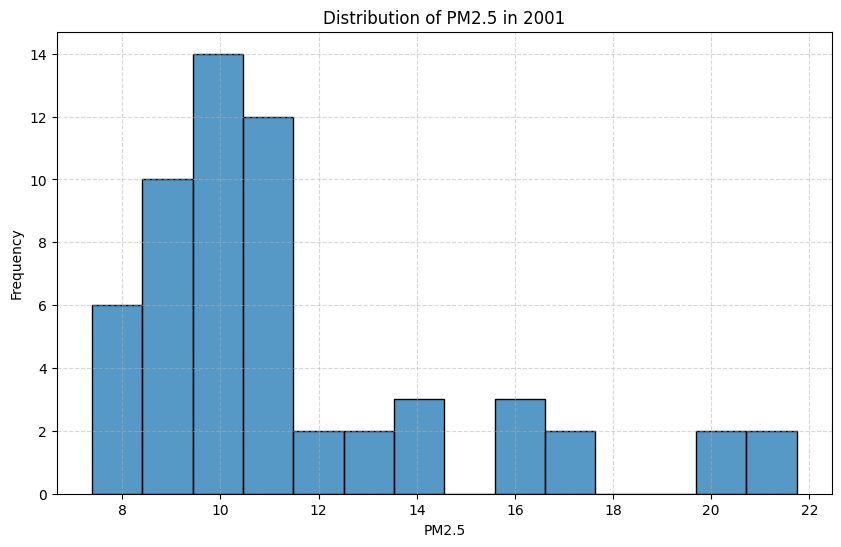

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(data=ca_air_quality[ca_air_quality['year'] == 2001], x='pm25_mean',binwidth=1)
plt.title('Distribution of PM2.5 in 2001')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [16]:
ca_air_quality[ca_air_quality['year'] == 2001].describe()

,year,pm25_mean
count,58.0,58.000000
mean,2001.0,11.557848
std,0.0,3.495027
min,2001.0,7.384451
25%,2001.0,9.227474
50%,2001.0,10.403761
75%,2001.0,12.036173
max,2001.0,21.741937


### Binarize Air Quality
Air quality category	PM2.5 µg/m3 averaged over 24 hours

- Good	Less than 12.5
- Fair	12.5–25
- Poor	25–50
- Very poor	50–150

https://www.epa.gov/sites/default/files/2016-04/documents/2012_aqi_factsheet.pdf

In [17]:
ca_air_quality_2001 = ca_air_quality[ca_air_quality['year'] == 2001]
trends_air_quality = pd.merge(ca_air_quality[ca_air_quality['year'] == 2001], ca_trends, left_on='county', right_on='county_name').drop(columns=['county_name','year'])
trends_air_quality['Air_quality'] = [1 if x <= 12 else 0 for x in trends_air_quality['pm25_mean']]
trends_air_quality.head()

,county,pm25_mean,kfr_p1,kfr_p25,kfr_p50,kfr_p75,kfr_p100,kir_p1,kir_p25,kir_p50,...,kii_p1,kfi_p25,kii_p25,kfi_p50,kii_p50,kfi_p75,kii_p75,kfi_p100,kii_p100,Air_quality
0,Alameda,11.337368,0.397131,0.454142,0.494372,0.560972,0.620201,0.423974,0.480677,0.519578,...,22839.928,31948.490,27306.277,35490.293,30319.748,41629.199,35054.789,47651.973,40606.148,1
1,Amador,10.403291,0.421679,0.477740,0.521561,0.564419,0.607557,0.418718,0.463691,0.498969,...,22421.004,34014.910,25981.512,37944.645,28730.098,41957.102,31834.590,46296.137,35787.031,1
2,Butte,10.039504,0.335972,0.420086,0.482973,0.551201,0.620764,0.340167,0.413760,0.468725,...,16051.436,28984.219,22025.777,34479.141,26376.275,40699.688,31191.508,47712.863,37937.078,1
3,Calaveras,10.343406,0.412029,0.469688,0.514277,0.561053,0.607578,0.391870,0.448704,0.491574,...,20281.033,33307.535,24806.279,37280.715,28155.248,41636.918,31924.805,46298.473,36986.430,1
4,Colusa,9.920628,0.441396,0.500426,0.537842,0.577317,0.625647,0.426208,0.487080,0.527387,...,23017.938,36034.262,27802.826,39438.016,30925.113,43221.762,34362.160,48242.590,40188.762,1


## Exploratory Data Analysis

In [134]:
# install folium
!pip install folium

In [18]:
import folium
geojson_url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson"

# Initialize Folium map
m = folium.Map(location=[37.5, -119.5], zoom_start=6)

# Add Choropleth layer
folium.Choropleth(
    geo_data=geojson_url,
    data=trends_air_quality,
    columns=["county", "pm25_mean"],
    key_on="feature.properties.name",  # GeoJSON field for county names
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="PM2.5 Levels"
).add_to(m)
m

In [19]:
# Initialize Folium map
o1 = folium.Map(location=[37.5, -119.5], zoom_start=6)

# Add Choropleth layer
folium.Choropleth(
    geo_data=geojson_url,
    data=trends_air_quality,
    columns=["county", "kir_p1"],
    key_on="feature.properties.name",  # GeoJSON field for county names
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Mean Percentile Rank (Parent: 1st Percentile)"
).add_to(o1)
o1

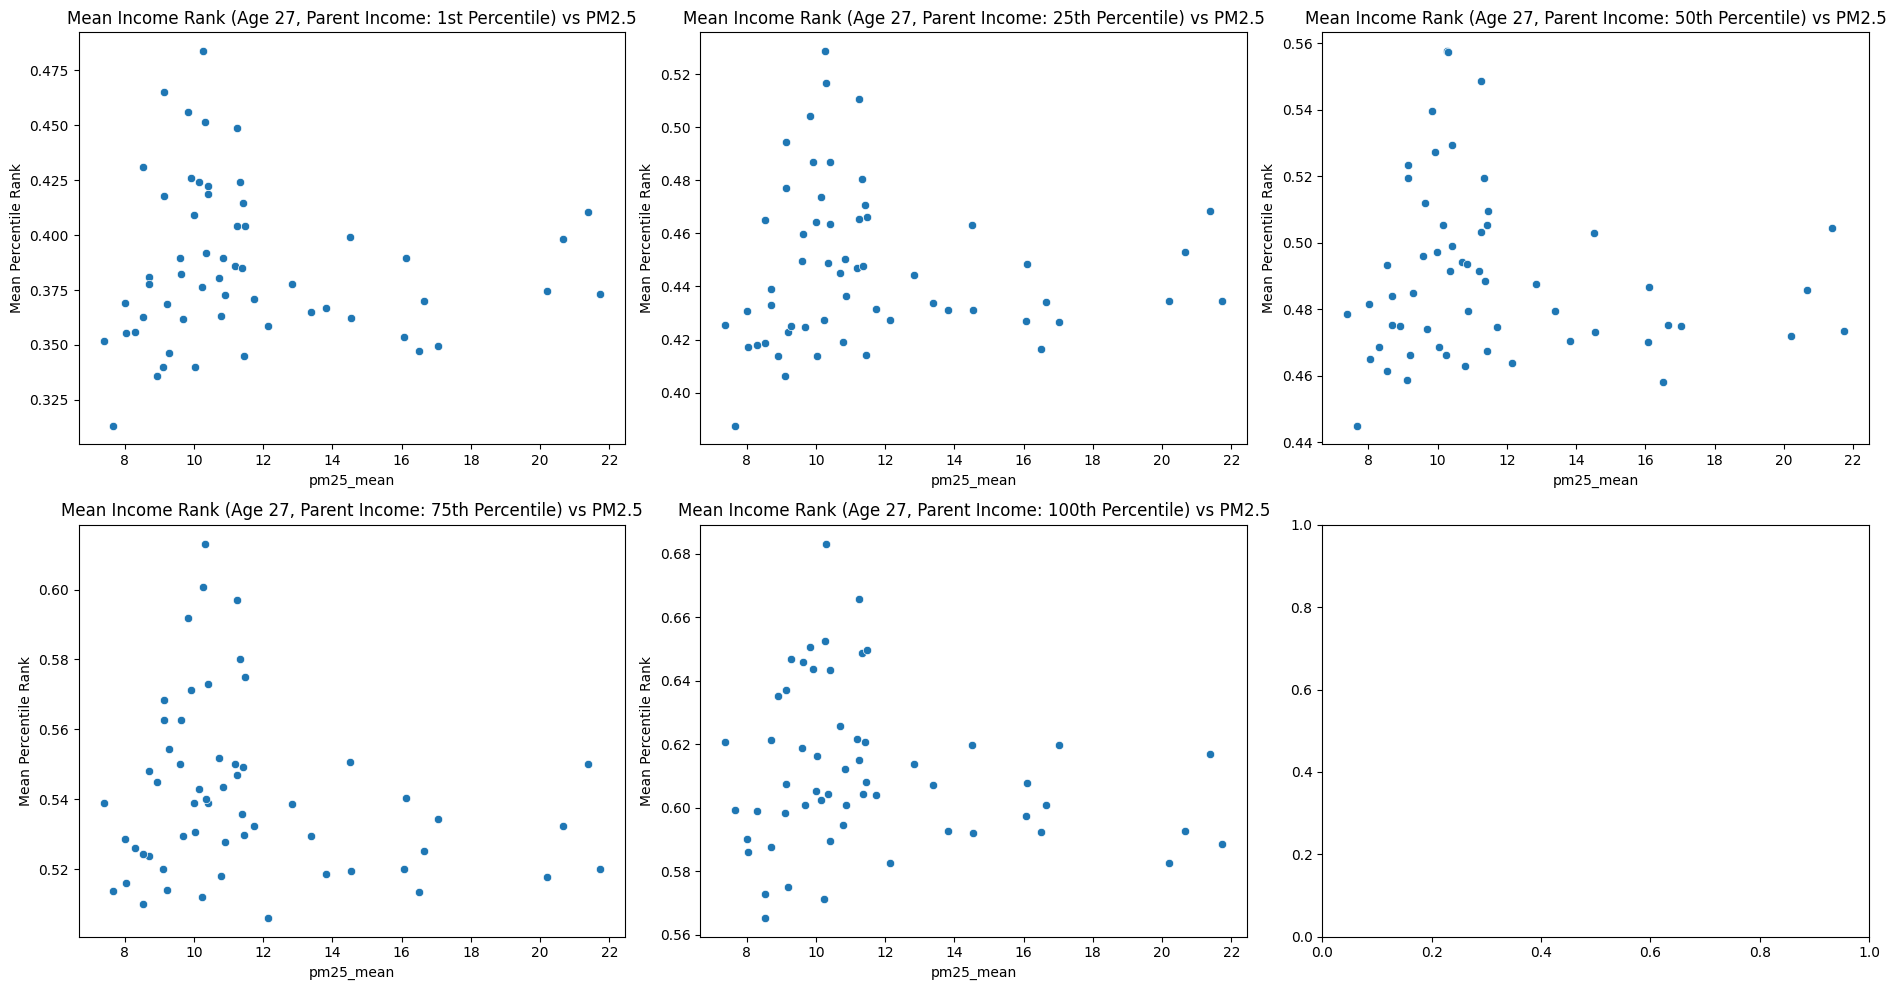

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(19, 10))


sns.scatterplot(data=trends_air_quality, x='pm25_mean', y='kir_p1',ax=axes[0,0])
axes[0,0].set_title('Mean Income Rank (Age 27, Parent Income: 1st Percentile) vs PM2.5')
axes[0,0].set_ylabel('Mean Percentile Rank')

sns.scatterplot(data=trends_air_quality, x='pm25_mean', y='kir_p25', ax=axes[0,1])
axes[0,1].set_title('Mean Income Rank (Age 27, Parent Income: 25th Percentile) vs PM2.5')
axes[0,1].set_ylabel('Mean Percentile Rank')

sns.scatterplot(data=trends_air_quality, x='pm25_mean', y='kir_p50',ax=axes[0,2])
axes[0,2].set_title('Mean Income Rank (Age 27, Parent Income: 50th Percentile) vs PM2.5')
axes[0,2].set_ylabel('Mean Percentile Rank')

sns.scatterplot(data=trends_air_quality, x='pm25_mean', y='kir_p75',ax=axes[1,0])
axes[1,0].set_title('Mean Income Rank (Age 27, Parent Income: 75th Percentile) vs PM2.5')
axes[1,0].set_ylabel('Mean Percentile Rank')

sns.scatterplot(data=trends_air_quality, x='pm25_mean', y='kir_p100',ax=axes[1,1])
axes[1,1].set_title('Mean Income Rank (Age 27, Parent Income: 100th Percentile) vs PM2.5')
axes[1,1].set_ylabel('Mean Percentile Rank')

plt.tight_layout()
plt.show()

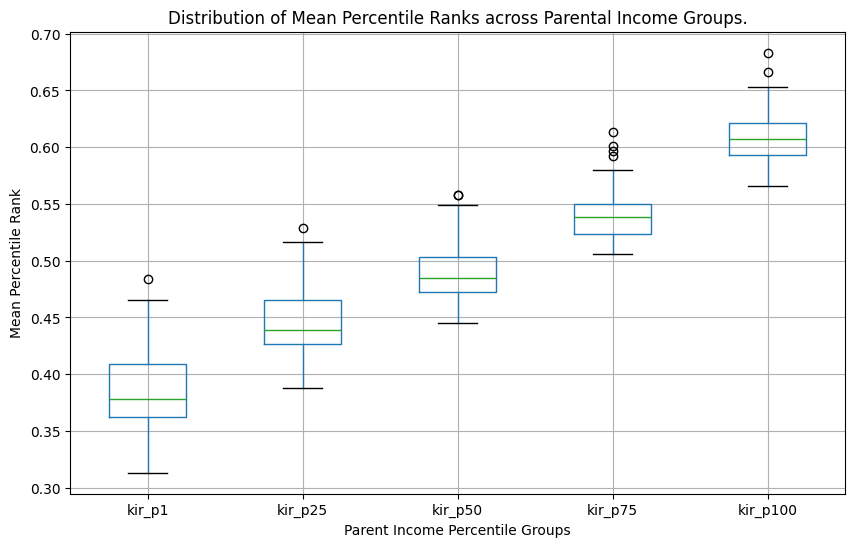

In [21]:
# Extract values from the specified columns
columns_of_interest = ['kir_p1', 'kir_p25', 'kir_p50', 'kir_p75', 'kir_p100']
values = trends_air_quality[columns_of_interest]

# Plot the distribution of the numbers across the columns
plt.figure(figsize=(10, 6))
values.boxplot()
plt.title('Distribution of Mean Percentile Ranks across Parental Income Groups.')
plt.ylabel('Mean Percentile Rank')
plt.xlabel('Parent Income Percentile Groups')
plt.xticks(ticks=[1, 2, 3, 4, 5], labels=columns_of_interest)
plt.show()

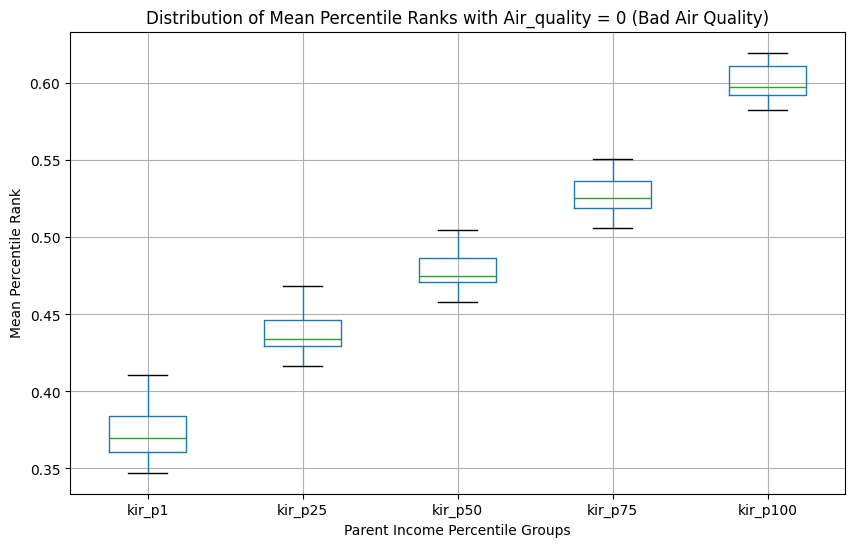

In [22]:
# Filter rows where 'Air_quality' is 0
filtered_data = trends_air_quality[trends_air_quality['Air_quality'] == 0]

# Extract values from the specified columns
columns_of_interest = ['kir_p1', 'kir_p25', 'kir_p50', 'kir_p75', 'kir_p100']
filtered_values = filtered_data[columns_of_interest]

# Plot the distribution of the numbers across the columns
plt.figure(figsize=(10, 6))
filtered_values.boxplot()
plt.title('Distribution of Mean Percentile Ranks with Air_quality = 0 (Bad Air Quality)')
plt.ylabel('Mean Percentile Rank')
plt.xlabel('Parent Income Percentile Groups')
plt.xticks(ticks=[1, 2, 3, 4, 5], labels=columns_of_interest)
plt.show()

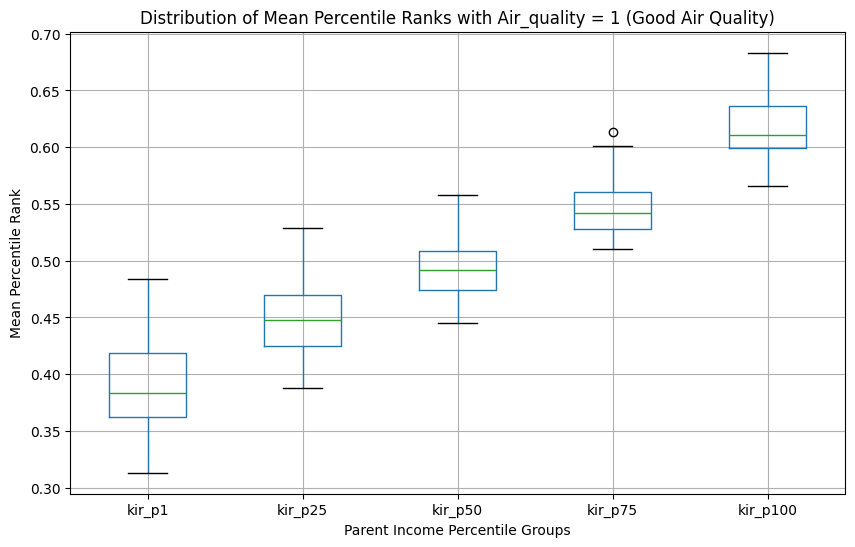

In [23]:
# Filter rows where 'Air_quality' is 1
filtered_data = trends_air_quality[trends_air_quality['Air_quality'] == 1]

# Extract values from the specified columns
columns_of_interest = ['kir_p1', 'kir_p25', 'kir_p50', 'kir_p75', 'kir_p100']
filtered_values = filtered_data[columns_of_interest]

# Plot the distribution of the numbers across the columns
plt.figure(figsize=(10, 6))
filtered_values.boxplot()
plt.title('Distribution of Mean Percentile Ranks with Air_quality = 1 (Good Air Quality)')
plt.ylabel('Mean Percentile Rank')
plt.xlabel('Parent Income Percentile Groups')
plt.xticks(ticks=[1, 2, 3, 4, 5], labels=columns_of_interest)
plt.show()

In [24]:
ca_covariates.head()

,county_name,emp_pooled2010,emp_pooled1990,emp_pooled2000,frac_coll_pooled2010,frac_coll_pooled1990,frac_coll_pooled2000,foreign_share1990,foreign_share2000,gini2010,...,percap_inc_pooled1990,percap_inc_pooled2000,poor_share_pooled2010,poor_share_pooled1990,poor_share_pooled2000,singlepar_pooled2010,singlepar_pooled1990,singlepar_pooled2000,pop_pooled2010,pop_pooled1990
0,Alameda,0.681232,0.725534,0.691786,0.402908,0.288066,0.349112,0.488427,0.728029,0.456,...,43129.324,48803.470249,0.114038,0.106206,0.110426,0.274512,0.290570,0.278850,1510271,1279182
1,Amador,0.533814,0.515726,0.563770,0.189883,0.139880,0.166464,0.623989,0.966382,0.399,...,35104.180,40996.378382,0.079927,0.084136,0.092180,0.313919,0.187456,0.286313,38091,30039
2,Butte,0.599567,0.610214,0.623440,0.241413,0.194756,0.218359,0.601801,0.922883,0.449,...,29699.188,32042.368379,0.184027,0.188717,0.197901,0.371994,0.287122,0.338576,220000,182120
3,Calaveras,0.621842,0.602924,0.608703,0.196097,0.144281,0.171090,0.620039,0.969941,0.412,...,33174.703,39181.796579,0.083047,0.100930,0.117871,0.293436,0.212884,0.277588,45578,31998
4,Colusa,0.627421,0.643913,0.603025,0.117466,0.110615,0.106488,0.597542,0.724474,0.429,...,30483.268,26944.344707,0.149605,0.132513,0.160685,0.257465,0.217510,0.219667,21419,16275


In [25]:
cols_2000 = [col for col in ca_covariates.columns if '2000' in col]
ca_covariates_2000 = ca_covariates[cols_2000]
ca_covariates_2000.columns

Index(['emp_pooled2000', 'frac_coll_pooled2000', 'foreign_share2000',
       'gini2000', 'hhinc_median_pooled2000', 'percap_inc_pooled2000',
       'poor_share_pooled2000', 'singlepar_pooled2000'],
      dtype='object')

In [26]:
ca_covariates_2000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   emp_pooled2000           57 non-null     float64
 1   frac_coll_pooled2000     57 non-null     float64
 2   foreign_share2000        57 non-null     float64
 3   gini2000                 57 non-null     float64
 4   hhinc_median_pooled2000  57 non-null     float64
 5   percap_inc_pooled2000    57 non-null     float64
 6   poor_share_pooled2000    57 non-null     float64
 7   singlepar_pooled2000     57 non-null     float64
dtypes: float64(8)
memory usage: 3.7 KB


In [27]:
ca_covariates_2000.head()

,emp_pooled2000,frac_coll_pooled2000,foreign_share2000,gini2000,hhinc_median_pooled2000,percap_inc_pooled2000,poor_share_pooled2000,singlepar_pooled2000
0,0.691786,0.349112,0.728029,0.451447,102337.291850,48803.470249,0.110426,0.278850
1,0.563770,0.166464,0.966382,0.428847,77339.232464,40996.378382,0.092180,0.286313
2,0.623440,0.218359,0.922883,0.468834,58395.876471,32042.368379,0.197901,0.338576
3,0.608703,0.171090,0.969941,0.439741,75038.079331,39181.796579,0.117871,0.277588
4,0.603025,0.106488,0.724474,0.432603,64135.954793,26944.344707,0.160685,0.219667


In [28]:
trends_covariates = pd.merge(trends_air_quality,ca_covariates,left_on='county', right_on='county_name').drop(columns=['county_name'])
trends_covariates.head()

,county,pm25_mean,kfr_p1,kfr_p25,kfr_p50,kfr_p75,kfr_p100,kir_p1,kir_p25,kir_p50,...,percap_inc_pooled1990,percap_inc_pooled2000,poor_share_pooled2010,poor_share_pooled1990,poor_share_pooled2000,singlepar_pooled2010,singlepar_pooled1990,singlepar_pooled2000,pop_pooled2010,pop_pooled1990
0,Alameda,11.337368,0.397131,0.454142,0.494372,0.560972,0.620201,0.423974,0.480677,0.519578,...,43129.324,48803.470249,0.114038,0.106206,0.110426,0.274512,0.290570,0.278850,1510271,1279182
1,Amador,10.403291,0.421679,0.477740,0.521561,0.564419,0.607557,0.418718,0.463691,0.498969,...,35104.180,40996.378382,0.079927,0.084136,0.092180,0.313919,0.187456,0.286313,38091,30039
2,Butte,10.039504,0.335972,0.420086,0.482973,0.551201,0.620764,0.340167,0.413760,0.468725,...,29699.188,32042.368379,0.184027,0.188717,0.197901,0.371994,0.287122,0.338576,220000,182120
3,Calaveras,10.343406,0.412029,0.469688,0.514277,0.561053,0.607578,0.391870,0.448704,0.491574,...,33174.703,39181.796579,0.083047,0.100930,0.117871,0.293436,0.212884,0.277588,45578,31998
4,Colusa,9.920628,0.441396,0.500426,0.537842,0.577317,0.625647,0.426208,0.487080,0.527387,...,30483.268,26944.344707,0.149605,0.132513,0.160685,0.257465,0.217510,0.219667,21419,16275


## Checking for Confounders by Plotting Distribution by Air Quality

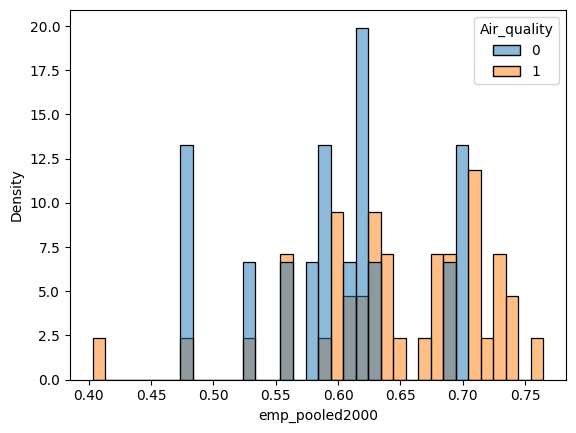

In [29]:
sns.histplot(data=trends_covariates, x='emp_pooled2000', hue='Air_quality', binwidth=0.01, stat='density', common_norm=False)
plt.show()

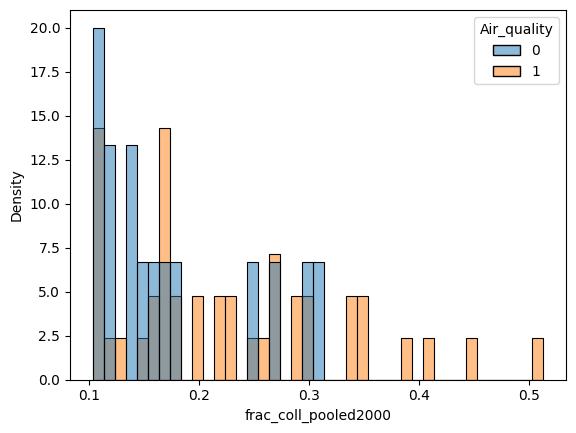

In [30]:
sns.histplot(data=trends_covariates, x='frac_coll_pooled2000', hue='Air_quality', binwidth=0.01, stat='density', common_norm=False)
plt.show()

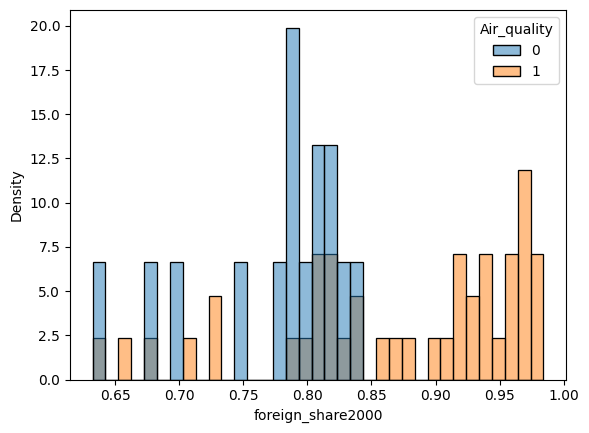

In [31]:
sns.histplot(data=trends_covariates, x='foreign_share2000', hue='Air_quality', binwidth=0.01, stat='density', common_norm=False)
plt.show()

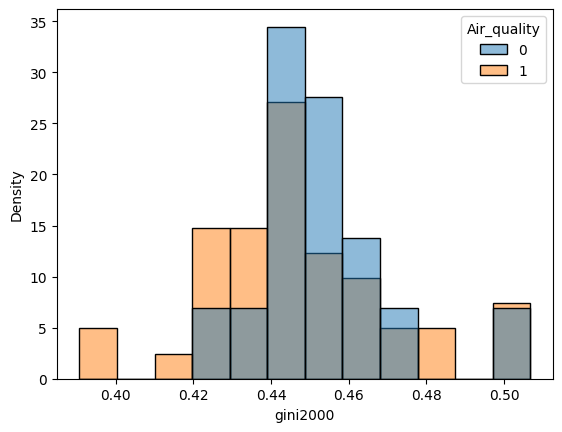

In [32]:
sns.histplot(data=trends_covariates, x='gini2000', hue='Air_quality', binwidth=0.01, stat='density', common_norm=False)
plt.show()

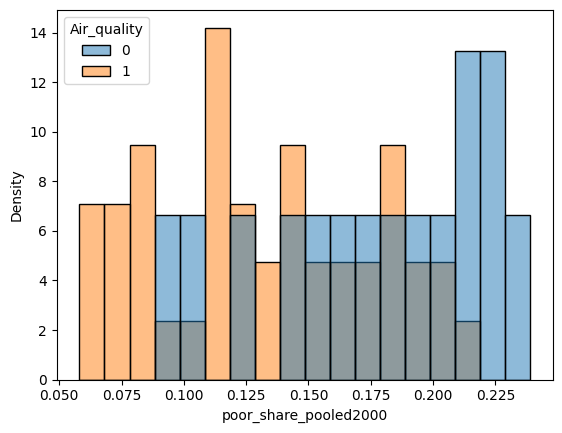

In [33]:
sns.histplot(data=trends_covariates, x='poor_share_pooled2000', hue='Air_quality', binwidth=0.01, stat='density', common_norm=False)
plt.show()

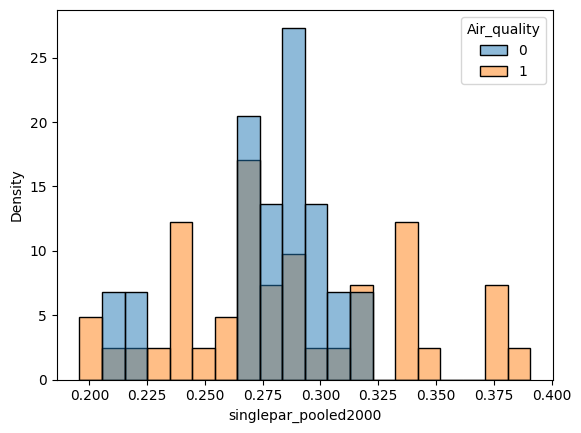

In [34]:
sns.histplot(data=trends_covariates, x='singlepar_pooled2000', hue='Air_quality', binwidth=0.01, stat='density', common_norm=False)
plt.show()

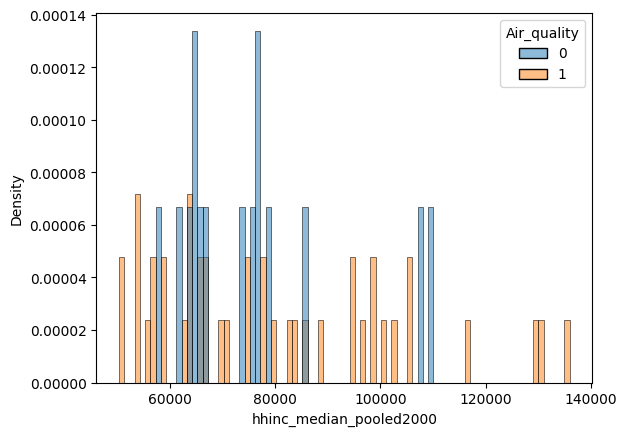

In [35]:
sns.histplot(data=trends_covariates, x='hhinc_median_pooled2000', hue='Air_quality',binwidth=1000, stat='density', common_norm=False)
plt.show()

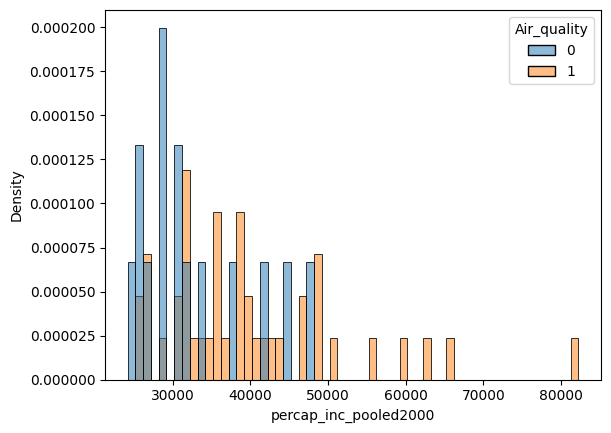

In [36]:
sns.histplot(data=trends_covariates, x='percap_inc_pooled2000', hue='Air_quality',binwidth=1000, stat='density', common_norm=False)
plt.show()

### Confounders:
'frac_coll_pooled2000', 'foreign_share2000',
 'percap_inc_pooled2000', 'poor_share_pooled2000'

## Controling for Confounder Method 1: Inverse Propensity Weighting

In [37]:
from sklearn.linear_model import LogisticRegression as LR

In [38]:
Z = trends_covariates['Air_quality']
X = trends_covariates[['frac_coll_pooled2000', 'foreign_share2000', 'percap_inc_pooled2000', 'poor_share_pooled2000']]

In [39]:
lr = LR(penalty=None, max_iter=200, random_state=0)
lr.fit(X, Z)

LogisticRegression(max_iter=200, penalty=None, random_state=0)

In [40]:
def estimate_treatment_effect(model, X, Y, Z):
    # Prob P(Z=1|X)
    e_x = lr.predict_proba(X)[:,1]
    # Restrict propensity scores to the range [0.1, 0.9]
    valid_indices = (e_x >= 0.1) & (e_x <= 0.9)
    e_x = e_x[valid_indices]
    Y = Y[valid_indices]
    Z = Z[valid_indices]

    tau_hat = np.mean(Z*Y/e_x - (1-Z)*Y/(1-e_x))
    return tau_hat

In [41]:
p1_treatment_effect = estimate_treatment_effect(lr, X, trends_covariates['kir_p1'], Z)
p1_treatment_effect

-0.1134383984643135

In [42]:
p25_treatment_effect = estimate_treatment_effect(lr, X, trends_covariates['kir_p25'], Z)
p25_treatment_effect

-0.136193979766845

In [43]:
p50_treatment_effect = estimate_treatment_effect(lr, X, trends_covariates['kir_p50'], Z)
p50_treatment_effect

-0.14781010990141114

In [44]:
p75_treatment_effect = estimate_treatment_effect(lr, X, trends_covariates['kir_p75'], Z)
p75_treatment_effect

-0.16395000749596048

In [45]:
p100_treatment_effect = estimate_treatment_effect(lr, X, trends_covariates['kir_p100'], Z)
p100_treatment_effect

-0.18699107999799328

# Controling for Confounder Method 2: Outcome Regression

In [46]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Check Linearity betwwen Air quality and Income Mobility

In [47]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(trends_air_quality['pm25_mean'], trends_air_quality['kir_p1'])
print("Assess linear relationship between pm2.5 and mean percentile rank of group with parent income at 1st percentile")
print(f"Pearson correlation coefficient: {corr}")
print(f"p-value: {p_value}")

Assess linear relationship between pm2.5 and mean percentile rank of group with parent income at 1st percentile
Pearson correlation coefficient: -0.042559735168787964
p-value: 0.7532607499809735


In [48]:
corr, p_value = pearsonr(trends_air_quality['pm25_mean'], trends_air_quality['kir_p25'])
print("Assess linear relationship between pm2.5 and mean percentile rank of group with parent income at 25th percentile")
print(f"Pearson correlation coefficient: {corr}")
print(f"p-value: {p_value}")

Assess linear relationship between pm2.5 and mean percentile rank of group with parent income at 25th percentile
Pearson correlation coefficient: -0.015130055248814122
p-value: 0.9110572772900956


In [49]:
corr, p_value = pearsonr(trends_air_quality['pm25_mean'], trends_air_quality['kir_p50'])
print("Assess linear relationship between pm2.5 and mean percentile rank of group with parent income at 50th percentile")
print(f"Pearson correlation coefficient: {corr}")
print(f"p-value: {p_value}")

Assess linear relationship between pm2.5 and mean percentile rank of group with parent income at 50th percentile
Pearson correlation coefficient: -0.10800968993895903
p-value: 0.42386564978164243


In [50]:
corr, p_value = pearsonr(trends_air_quality['pm25_mean'], trends_air_quality['kir_p75'])
print("Assess linear relationship between pm2.5 and mean percentile rank of group with parent income at 75th percentile")
print(f"Pearson correlation coefficient: {corr}")
print(f"p-value: {p_value}")

Assess linear relationship between pm2.5 and mean percentile rank of group with parent income at 75th percentile
Pearson correlation coefficient: -0.1690784820765397
p-value: 0.20864177883297647


In [51]:
corr, p_value = pearsonr(trends_air_quality['pm25_mean'], trends_air_quality['kir_p100'])
print("Assess linear relationship between pm2.5 and mean percentile rank of group with parent income at 100th percentile")
print(f"Pearson correlation coefficient: {corr}")
print(f"p-value: {p_value}")

Assess linear relationship between pm2.5 and mean percentile rank of group with parent income at 100th percentile
Pearson correlation coefficient: -0.15057684767100285
p-value: 0.26355280884533844


### Try Running Outcome Regression Despite not Having Linearity

In [52]:
observed_features = ['Air_quality' ,'frac_coll_pooled2000', 'foreign_share2000', 'percap_inc_pooled2000', 'poor_share_pooled2000']


In [53]:
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)

    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

def mean_squared_error(true_vals, predicted_vals):
    return np.mean((true_vals - predicted_vals) ** 2)

def draw_tau_hat(outcome, data=trends_covariates, features=observed_features, random_state=None):
    sample = data.sample(frac=1, random_state=random_state, replace=True)
    fit_model = fit_OLS_model(sample, outcome, features)
    estimated_ate = fit_model.params['Air_quality']
    return estimated_ate

def get_bootstrapped_ate(outcome, data=trends_covariates , n=1000):
    estimates = []
    for i in np.arange(n):
        estimates.append(draw_tau_hat(outcome))
    return estimates

Individual Income for 1 percentile
                                 OLS Regression Results                                
Dep. Variable:                 kir_p1   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              1243.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    8.26e-53
Time:                        19:51:27   Log-Likelihood:                          109.74
No. Observations:                  57   AIC:                                     -209.5
Df Residuals:                      52   BIC:                                     -199.3
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.

Text(0.5, 1.0, 'Bootstrapped Estimates of the ATE for 1 percentile')

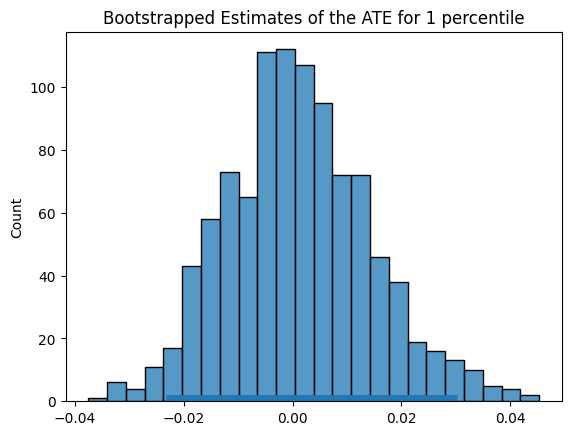

In [54]:
p1_model = fit_OLS_model(trends_covariates, 'kir_p1', observed_features)
print('Individual Income for 1 percentile')
print(p1_model.summary())

p1_ates = get_bootstrapped_ate('kir_p1')
confidence_interval = [np.percentile(p1_ates, 2.5),
                       np.percentile(p1_ates, 97.5)]
print(f"Our 95% confidence interval ranges from {np.round(confidence_interval[0], 3)} to {np.round(confidence_interval[1], 3)}")
sns.histplot(p1_ates)
plt.hlines(1, confidence_interval[0], confidence_interval[1], linewidth=5)
plt.title("Bootstrapped Estimates of the ATE for 1 percentile")

Individual Income for 25 percentile
                                 OLS Regression Results                                
Dep. Variable:                kir_p25   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              1675.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    3.74e-56
Time:                        19:51:29   Log-Likelihood:                          109.90
No. Observations:                  57   AIC:                                     -209.8
Df Residuals:                      52   BIC:                                     -199.6
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0

Text(0.5, 1.0, 'Bootstrapped Estimates of the ATE for 25 percentile')

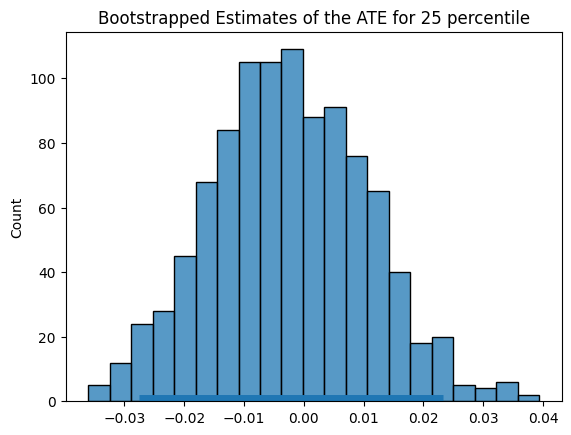

In [55]:
p25_model = fit_OLS_model(trends_covariates, 'kir_p25', observed_features)
print('Individual Income for 25 percentile')
print(p25_model.summary())

p25_ates = get_bootstrapped_ate('kir_p25')
confidence_interval = [np.percentile(p25_ates, 2.5),
                       np.percentile(p25_ates, 97.5)]
print(f"Our 95% confidence interval ranges from {np.round(confidence_interval[0], 3)} to {np.round(confidence_interval[1], 3)}")
sns.histplot(p25_ates)
plt.hlines(1, confidence_interval[0], confidence_interval[1], linewidth=5)
plt.title("Bootstrapped Estimates of the ATE for 25 percentile")

Individual Income for 50 percentile
                                 OLS Regression Results                                
Dep. Variable:                kir_p50   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              2093.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    1.18e-58
Time:                        19:51:31   Log-Likelihood:                          111.05
No. Observations:                  57   AIC:                                     -212.1
Df Residuals:                      52   BIC:                                     -201.9
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0

Text(0.5, 1.0, 'Bootstrapped Estimates of the ATE for 50 percentile')

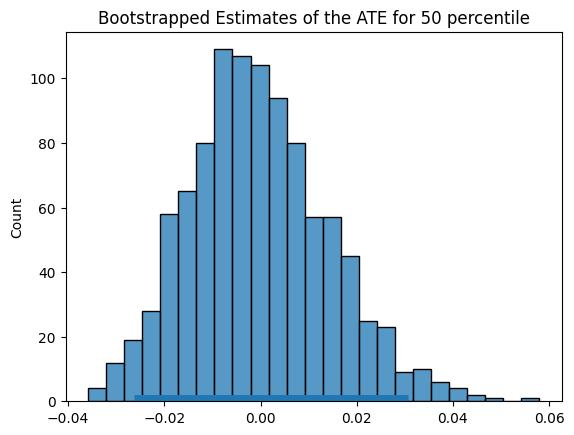

In [56]:
p50_model = fit_OLS_model(trends_covariates, 'kir_p50', observed_features)
print('Individual Income for 50 percentile')
print(p50_model.summary())

p50_ates = get_bootstrapped_ate('kir_p50')
confidence_interval = [np.percentile(p50_ates, 2.5),
                       np.percentile(p50_ates, 97.5)]
print(f"Our 95% confidence interval ranges from {np.round(confidence_interval[0], 3)} to {np.round(confidence_interval[1], 3)}")
sns.histplot(p50_ates)
plt.hlines(1, confidence_interval[0], confidence_interval[1], linewidth=5)
plt.title("Bootstrapped Estimates of the ATE for 50 percentile")

Individual Income for 75 percentile
                                 OLS Regression Results                                
Dep. Variable:                kir_p75   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              2484.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    1.41e-60
Time:                        19:51:33   Log-Likelihood:                          110.24
No. Observations:                  57   AIC:                                     -210.5
Df Residuals:                      52   BIC:                                     -200.3
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0

Text(0.5, 1.0, 'Bootstrapped Estimates of the ATE for 75 percentile')

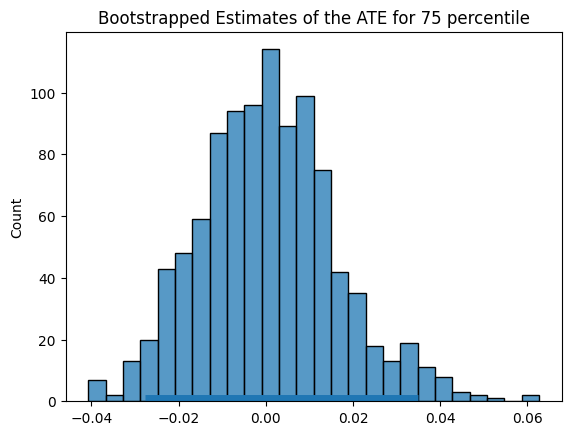

In [57]:
p75_model = fit_OLS_model(trends_covariates, 'kir_p75', observed_features)
print('Individual Income for 75 percentile')
print(p75_model.summary())

p75_ates = get_bootstrapped_ate('kir_p75')
confidence_interval = [np.percentile(p75_ates, 2.5),
                       np.percentile(p75_ates, 97.5)]
print(f"Our 95% confidence interval ranges from {np.round(confidence_interval[0], 3)} to {np.round(confidence_interval[1], 3)}")
sns.histplot(p75_ates)
plt.hlines(1, confidence_interval[0], confidence_interval[1], linewidth=5)
plt.title("Bootstrapped Estimates of the ATE for 75 percentile")

Individual Income for 100 percentile
                                 OLS Regression Results                                
Dep. Variable:               kir_p100   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              2376.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    4.46e-60
Time:                        19:51:35   Log-Likelihood:                          102.03
No. Observations:                  57   AIC:                                     -194.1
Df Residuals:                      52   BIC:                                     -183.8
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      

Text(0.5, 1.0, 'Bootstrapped Estimates of the ATE for 100 percentile')

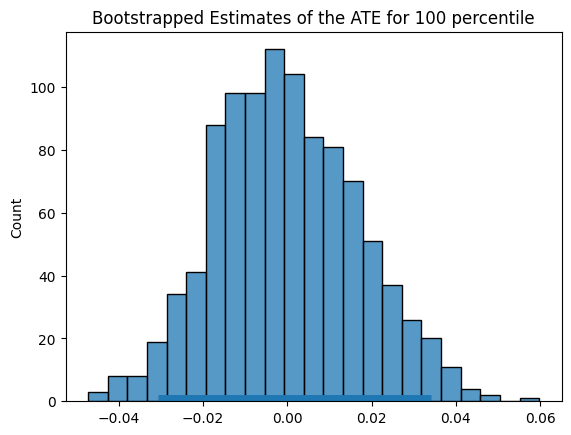

In [58]:
p100_model = fit_OLS_model(trends_covariates, 'kir_p100', observed_features)
print('Individual Income for 100 percentile')
print(p100_model.summary())

p100_ates = get_bootstrapped_ate('kir_p100')
confidence_interval = [np.percentile(p100_ates, 2.5),
                       np.percentile(p100_ates, 97.5)]
print(f"Our 95% confidence interval ranges from {np.round(confidence_interval[0], 3)} to {np.round(confidence_interval[1], 3)}")
sns.histplot(p100_ates)
plt.hlines(1, confidence_interval[0], confidence_interval[1], linewidth=5)
plt.title("Bootstrapped Estimates of the ATE for 100 percentile")

# Research Question 2: How well does air quality predict socioeconomic mobility of county children?

## Non-parametric Prediction

In [59]:
# Import the data
ca_air_quality = pd.read_csv('ca_air_quality.csv')
ca_trends = pd.read_csv('ca_trends.csv')

# Pivot data to get annual air quality as columns representing our features
ca_air_quality['county'] = ca_air_quality['county'].str.replace(' County', '', case=False).str.strip()
pm25_pivot = ca_air_quality.pivot(index="county", columns="year", values="pm25_mean")
pm25_pivot.columns = [f"pm25_{year}" for year in pm25_pivot.columns]
pm25_pivot.reset_index(inplace=True)
pm25_pivot.head(5)

,county,pm25_2001,pm25_2002,pm25_2003,pm25_2004,pm25_2005,pm25_2006,pm25_2007,pm25_2008,pm25_2009,pm25_2010,pm25_2011,pm25_2012,pm25_2013,pm25_2014
0,Alameda,11.337368,12.515194,11.746714,10.519771,10.046940,10.537818,10.250983,12.302362,10.709889,9.295202,9.900472,8.244112,11.000615,8.970681
1,Alpine,7.686804,8.902171,8.080624,8.087348,7.934023,7.889818,5.296605,7.053058,6.361883,5.676465,6.121720,4.880946,6.543713,5.618063
2,Amador,10.403291,12.218641,11.029036,10.650562,10.286229,10.670561,8.739039,10.444600,8.417258,6.972696,7.685671,6.842723,8.366759,7.391469
3,Butte,10.039504,11.240247,10.582500,9.622950,9.575341,9.548045,8.434938,11.905424,8.135903,6.726448,7.720789,6.901922,8.653571,8.281286
4,Calaveras,10.343406,11.958018,11.248459,10.422676,10.063839,10.441275,8.278623,9.953259,8.239809,6.911949,7.490275,6.564585,8.256749,7.397673


In [60]:
# Add mobility outcomes
ca_trends = ca_trends[[column for column in ca_trends.columns if "kir" in column] + ['county_name']]
pm25_trends = pd.merge(pm25_pivot, ca_trends, left_on='county', right_on='county_name').drop(columns=['county_name'])
pm25_trends.head(5)

,county,pm25_2001,pm25_2002,pm25_2003,pm25_2004,pm25_2005,pm25_2006,pm25_2007,pm25_2008,pm25_2009,pm25_2010,pm25_2011,pm25_2012,pm25_2013,pm25_2014,kir_p1,kir_p25,kir_p50,kir_p75,kir_p100
0,Alameda,11.337368,12.515194,11.746714,10.519771,10.046940,10.537818,10.250983,12.302362,10.709889,9.295202,9.900472,8.244112,11.000615,8.970681,0.423974,0.480677,0.519578,0.580212,0.648633
1,Amador,10.403291,12.218641,11.029036,10.650562,10.286229,10.670561,8.739039,10.444600,8.417258,6.972696,7.685671,6.842723,8.366759,7.391469,0.418718,0.463691,0.498969,0.539051,0.589476
2,Butte,10.039504,11.240247,10.582500,9.622950,9.575341,9.548045,8.434938,11.905424,8.135903,6.726448,7.720789,6.901922,8.653571,8.281286,0.340167,0.413760,0.468725,0.530784,0.616269
3,Calaveras,10.343406,11.958018,11.248459,10.422676,10.063839,10.441275,8.278623,9.953259,8.239809,6.911949,7.490275,6.564585,8.256749,7.397673,0.391870,0.448704,0.491574,0.540220,0.604524
4,Colusa,9.920628,11.080532,10.758623,9.244025,9.036551,9.721230,7.110535,10.410877,7.106684,5.625827,6.696528,6.214777,7.193123,7.646409,0.426208,0.487080,0.527387,0.571380,0.643638


In [61]:
# Extract the data for each model
p1_data = pd.concat([pm25_trends.iloc[:, 1:11], pm25_trends.iloc[:, 15]], axis=1)
p25_data = pd.concat([pm25_trends.iloc[:, 1:11], pm25_trends.iloc[:, 16]], axis=1)
p50_data = pd.concat([pm25_trends.iloc[:, 1:11], pm25_trends.iloc[:, 17]], axis=1)
p75_data = pd.concat([pm25_trends.iloc[:, 1:11], pm25_trends.iloc[:, 18]], axis=1)
p100_data = pd.concat([pm25_trends.iloc[:, 1:11], pm25_trends.iloc[:, 19]], axis=1)

In [62]:
p1_data.head(5)

,pm25_2001,pm25_2002,pm25_2003,pm25_2004,pm25_2005,pm25_2006,pm25_2007,pm25_2008,pm25_2009,pm25_2010,kir_p1
0,11.337368,12.515194,11.746714,10.519771,10.046940,10.537818,10.250983,12.302362,10.709889,9.295202,0.423974
1,10.403291,12.218641,11.029036,10.650562,10.286229,10.670561,8.739039,10.444600,8.417258,6.972696,0.418718
2,10.039504,11.240247,10.582500,9.622950,9.575341,9.548045,8.434938,11.905424,8.135903,6.726448,0.340167
3,10.343406,11.958018,11.248459,10.422676,10.063839,10.441275,8.278623,9.953259,8.239809,6.911949,0.391870
4,9.920628,11.080532,10.758623,9.244025,9.036551,9.721230,7.110535,10.410877,7.106684,5.625827,0.426208


In [63]:
# Split the data
p1_train, p1_test = train_test_split(p1_data, test_size=0.3, random_state=102)
p25_train, p25_test = train_test_split(p25_data, test_size=0.3, random_state=102)
p50_train, p50_test = train_test_split(p50_data, test_size=0.3, random_state=102)
p75_train, p75_test = train_test_split(p75_data, test_size=0.3, random_state=102)
p100_train, p100_test = train_test_split(p100_data, test_size=0.3, random_state=102)

# Train the Decision Tree models, and test them
p1_tree = DecisionTreeRegressor()
p1_tree.fit(p1_train.iloc[:, :-1], p1_train.iloc[:, -1])
p1_train["tree_pred"] = p1_tree.predict(p1_train.iloc[:, :-1])
p1_test["tree_pred"] = p1_tree.predict(p1_test.iloc[:, :-1])

p25_tree = DecisionTreeRegressor()
p25_tree.fit(p25_train.iloc[:, :-1], p25_train.iloc[:, -1])
p25_train["tree_pred"] = p25_tree.predict(p25_train.iloc[:, :-1])
p25_test["tree_pred"] = p25_tree.predict(p25_test.iloc[:, :-1])

p50_tree = DecisionTreeRegressor()
p50_tree.fit(p50_train.iloc[:, :-1], p50_train.iloc[:, -1])
p50_train["tree_pred"] = p50_tree.predict(p50_train.iloc[:, :-1])
p50_test["tree_pred"] = p50_tree.predict(p50_test.iloc[:, :-1])

p75_tree = DecisionTreeRegressor()
p75_tree.fit(p75_train.iloc[:, :-1], p75_train.iloc[:, -1])
p75_train["tree_pred"] = p75_tree.predict(p75_train.iloc[:, :-1])
p75_test["tree_pred"] = p75_tree.predict(p75_test.iloc[:, :-1])

p100_tree = DecisionTreeRegressor()
p100_tree.fit(p100_train.iloc[:, :-1], p100_train.iloc[:, -1])
p100_train["tree_pred"] = p100_tree.predict(p100_train.iloc[:, :-1])
p100_test["tree_pred"] = p100_tree.predict(p100_test.iloc[:, :-1])

In [64]:
# Get the train error
datasets = [p1_train, p25_train, p50_train, p75_train, p100_train]
for data in datasets:
  train_rmse = np.mean((data["tree_pred"] - data.iloc[:, -2]) ** 2) ** 0.5
  print(f"Training set error for decision tree, {data.iloc[:, -2].name}: ", train_rmse)

Training set error for decision tree, kir_p1:  0.0
Training set error for decision tree, kir_p25:  0.0
Training set error for decision tree, kir_p50:  0.0
Training set error for decision tree, kir_p75:  0.0
Training set error for decision tree, kir_p100:  0.0


In [65]:
# Get the test error
datasets = [p1_test, p25_test, p50_test, p75_test, p100_test]
results = {}
for data in datasets:
  test_rmse = np.mean((data["tree_pred"] - data.iloc[:, -2]) ** 2) ** 0.5
  results[f"Decisions tree {data.iloc[:, -2].name}"] = test_rmse
  print(f"Test set error for decision tree, {data.iloc[:, -2].name}: ", test_rmse)

Test set error for decision tree, kir_p1:  0.056167795841261955
Test set error for decision tree, kir_p25:  0.030862562333348144
Test set error for decision tree, kir_p50:  0.031923604934936026
Test set error for decision tree, kir_p75:  0.026775950589709444
Test set error for decision tree, kir_p100:  0.029705947204635274


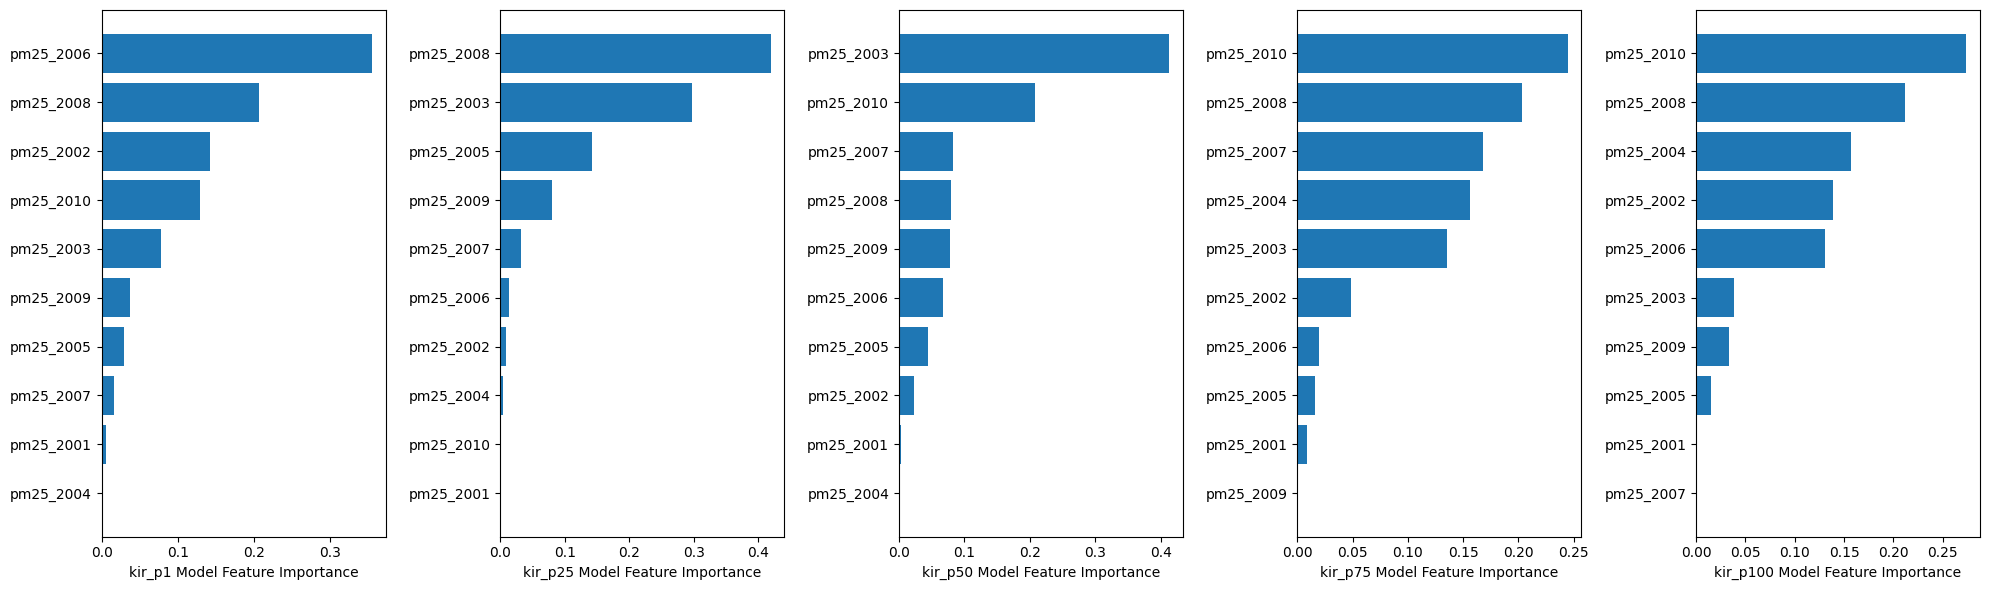

In [66]:
# Plot feature importance for each model
models = [p1_tree, p25_tree, p50_tree, p75_tree, p100_tree]
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

for i, (model, data) in enumerate(zip(models, datasets)):
    importances = model.feature_importances_
    sorted_idx = importances.argsort()
    feature_names = data.iloc[:, :-1].columns

    axes[i].barh(range(len(sorted_idx)), importances[sorted_idx], align="center")
    axes[i].set_yticks(range(len(sorted_idx)))
    axes[i].set_yticklabels(feature_names[sorted_idx])
    axes[i].set_xlabel(f"{data.iloc[:, -2].name} Model Feature Importance")

plt.tight_layout()
plt.show()

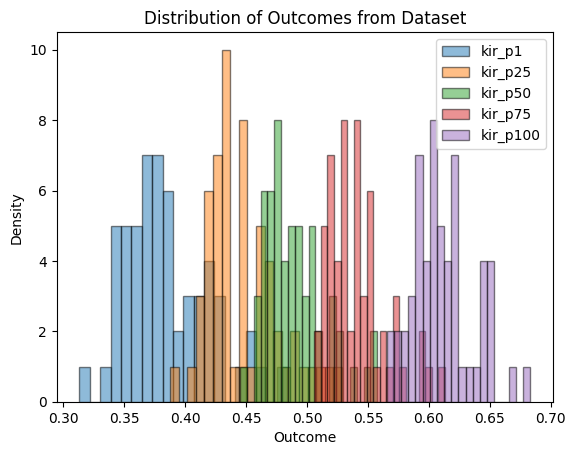

In [67]:
# Plot the distributions for each set of outcomes
for column in pm25_trends.iloc[:, 15:].columns:
  plt.hist(pm25_trends[column], bins=20, alpha=0.50, label=column, edgecolor='black')
plt.title("Distribution of Outcomes from Dataset")
plt.xlabel("Outcome")
plt.ylabel("Density")
plt.legend(loc='upper right')
plt.show()

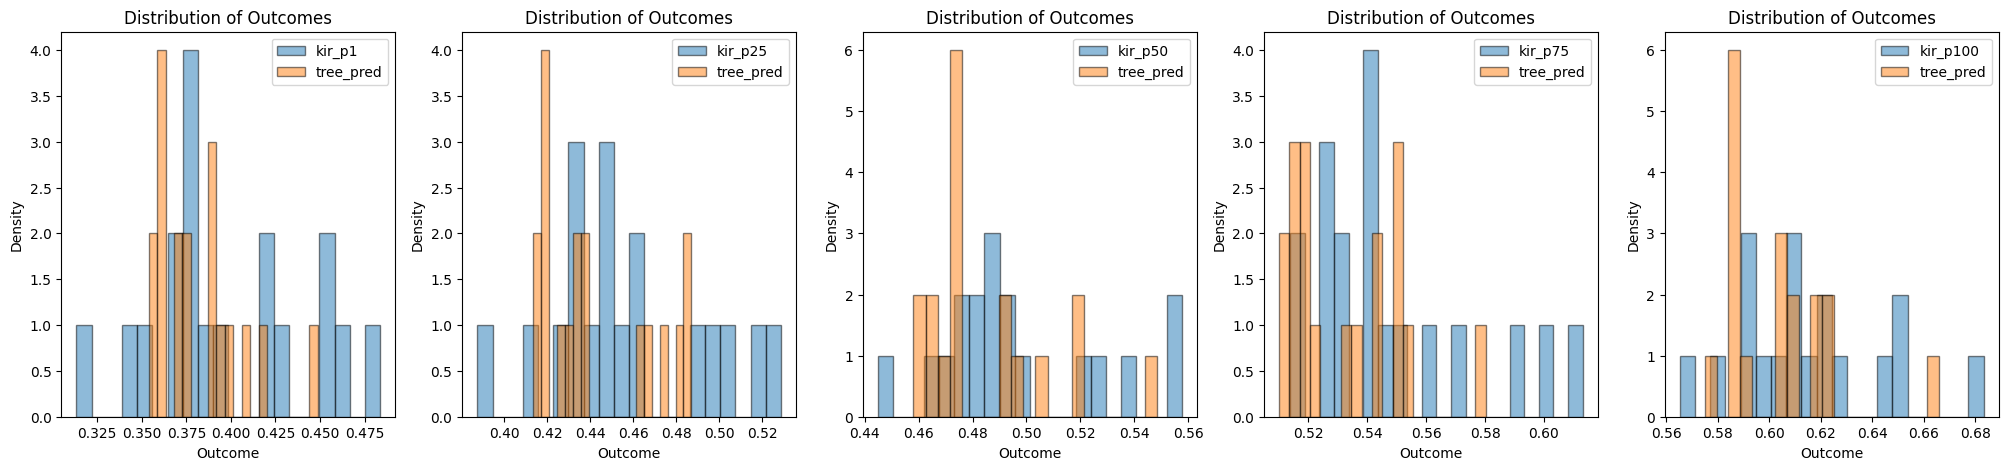

In [68]:
# Plot the distributions for each set of outcomes
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
axes = axes.flatten()

for i, data in enumerate(datasets):
  axes[i].hist(data.iloc[:, -2], bins=20, alpha=0.50, label=data.iloc[:, -2].name, edgecolor='black')
  axes[i].hist(data.iloc[:, -1], bins=20, alpha=0.50, label=data.iloc[:, -1].name, edgecolor='black')
  axes[i].set_title("Distribution of Outcomes")
  axes[i].set_xlabel("Outcome")
  axes[i].set_ylabel("Density")
  axes[i].legend(loc='upper right')

# Add additional metrics for evaluating model, could also compare to a naive model
# Plot feature importance

In [69]:
# Train RandomForestRegressor models, and test them
p1_rf = RandomForestRegressor(max_features=2)
p1_rf.fit(p1_train.iloc[:, :-2], p1_train.iloc[:, -2])
p1_train["forest_pred"] = p1_rf.predict(p1_train.iloc[:, :-2])
p1_test["forest_pred"] = p1_rf.predict(p1_test.iloc[:, :-2])

p25_rf = RandomForestRegressor(max_features=2)
p25_rf.fit(p25_train.iloc[:, :-2], p25_train.iloc[:, -2])
p25_train["forest_pred"] = p25_rf.predict(p25_train.iloc[:, :-2])
p25_test["forest_pred"] = p25_rf.predict(p25_test.iloc[:, :-2])

p50_rf = RandomForestRegressor(max_features=2)
p50_rf.fit(p50_train.iloc[:, :-2], p50_train.iloc[:, -2])
p50_train["forest_pred"] = p50_rf.predict(p50_train.iloc[:, :-2])
p50_test["forest_pred"] = p50_rf.predict(p50_test.iloc[:, :-2])

p75_rf = RandomForestRegressor(max_features=2)
p75_rf.fit(p75_train.iloc[:, :-2], p75_train.iloc[:, -2])
p75_train["forest_pred"] = p75_rf.predict(p75_train.iloc[:, :-2])
p75_test["forest_pred"] = p75_rf.predict(p75_test.iloc[:, :-2])

p100_rf = RandomForestRegressor(max_features=2)
p100_rf.fit(p100_train.iloc[:, :-2], p100_train.iloc[:, -2])
p100_train["forest_pred"] = p100_rf.predict(p100_train.iloc[:, :-2])
p100_test["forest_pred"] = p100_rf.predict(p100_test.iloc[:, :-2])

In [70]:
# Get the train error
datasets = [p1_train, p25_train, p50_train, p75_train, p100_train]
for data in datasets:
  train_rmse = np.mean((data["forest_pred"] - data.iloc[:, -3]) ** 2) ** 0.5
  print(f"Training set error for random forest, {data.iloc[:, -3].name}: ", train_rmse)

Training set error for random forest, kir_p1:  0.009032903022268016
Training set error for random forest, kir_p25:  0.008606965396098908
Training set error for random forest, kir_p50:  0.0076972016674659305
Training set error for random forest, kir_p75:  0.007122552573760198
Training set error for random forest, kir_p100:  0.007805611828370386


In [71]:
# Get the test error
datasets = [p1_test, p25_test, p50_test, p75_test, p100_test]
for data in datasets:
  test_rmse = np.mean((data["forest_pred"] - data.iloc[:, -3]) ** 2) ** 0.5
  results[f"Random forest {data.iloc[:, -3].name}"] = test_rmse
  print(f"Test set error for random forest, {data.iloc[:, -3].name}: ", test_rmse)

Test set error for random forest, kir_p1:  0.04773683830296426
Test set error for random forest, kir_p25:  0.03735874986606939
Test set error for random forest, kir_p50:  0.029304003039582017
Test set error for random forest, kir_p75:  0.026778756365573093
Test set error for random forest, kir_p100:  0.025943903660550775


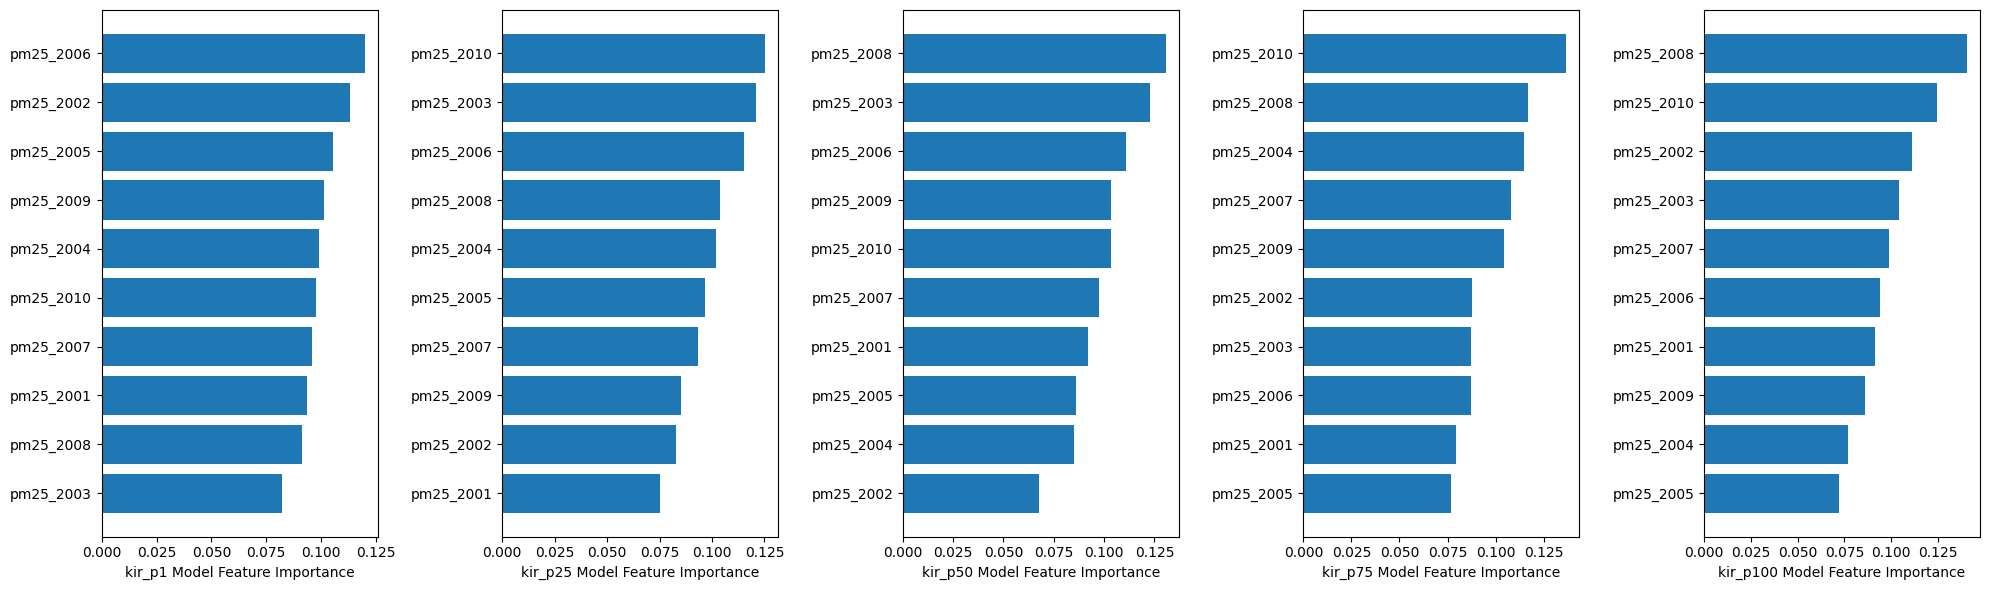

In [72]:
# Plot feature importance for each model
models = [p1_rf, p25_rf, p50_rf, p75_rf, p100_rf]
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

for i, (model, data) in enumerate(zip(models, datasets)):
    importances = model.feature_importances_
    sorted_idx = importances.argsort()
    feature_names = data.iloc[:, :-1].columns

    axes[i].barh(range(len(sorted_idx)), importances[sorted_idx], align="center")
    axes[i].set_yticks(range(len(sorted_idx)))
    axes[i].set_yticklabels(feature_names[sorted_idx])
    axes[i].set_xlabel(f"{data.iloc[:, -3].name} Model Feature Importance")

plt.tight_layout()
plt.show()

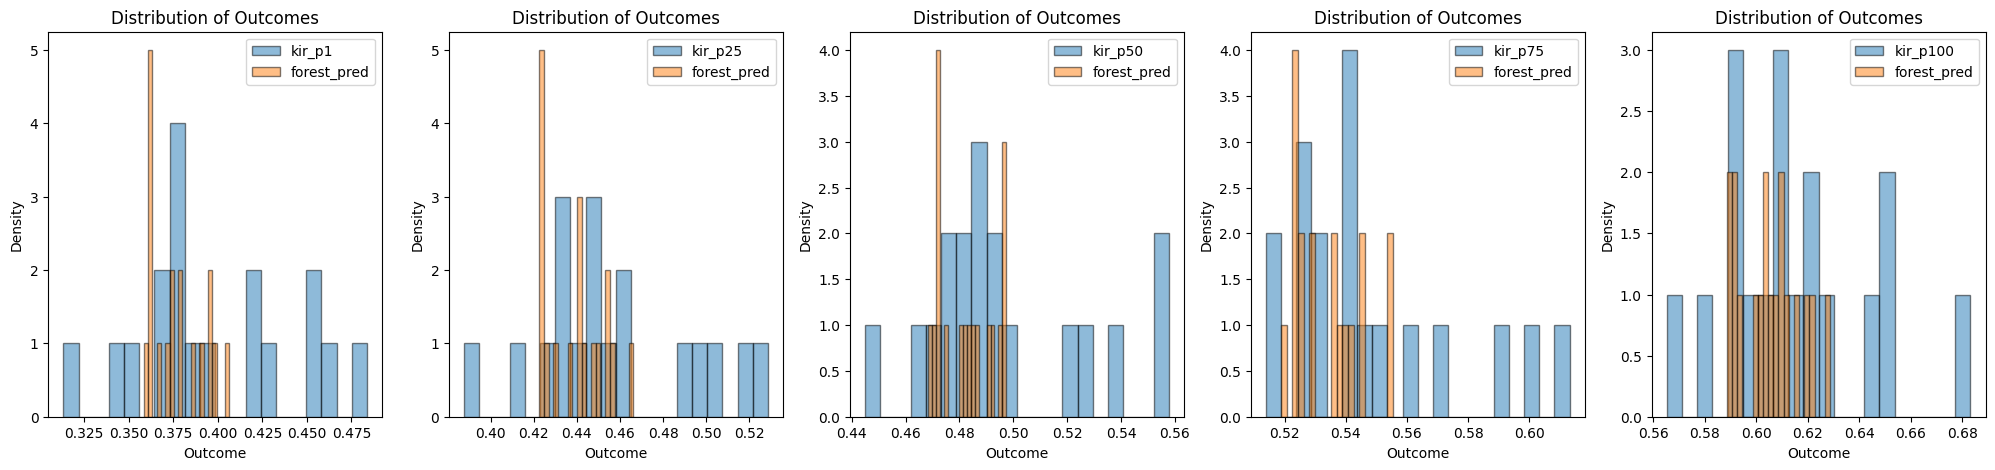

In [73]:
# Plot the distributions for each set of outcomes
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
axes = axes.flatten()

for i, data in enumerate(datasets):
  axes[i].hist(data.iloc[:, -3], bins=20, alpha=0.50, label=data.iloc[:, -3].name, edgecolor='black')
  axes[i].hist(data.iloc[:, -1], bins=20, alpha=0.50, label=data.iloc[:, -1].name, edgecolor='black')
  axes[i].set_title("Distribution of Outcomes")
  axes[i].set_xlabel("Outcome")
  axes[i].set_ylabel("Density")
  axes[i].legend(loc='upper right')

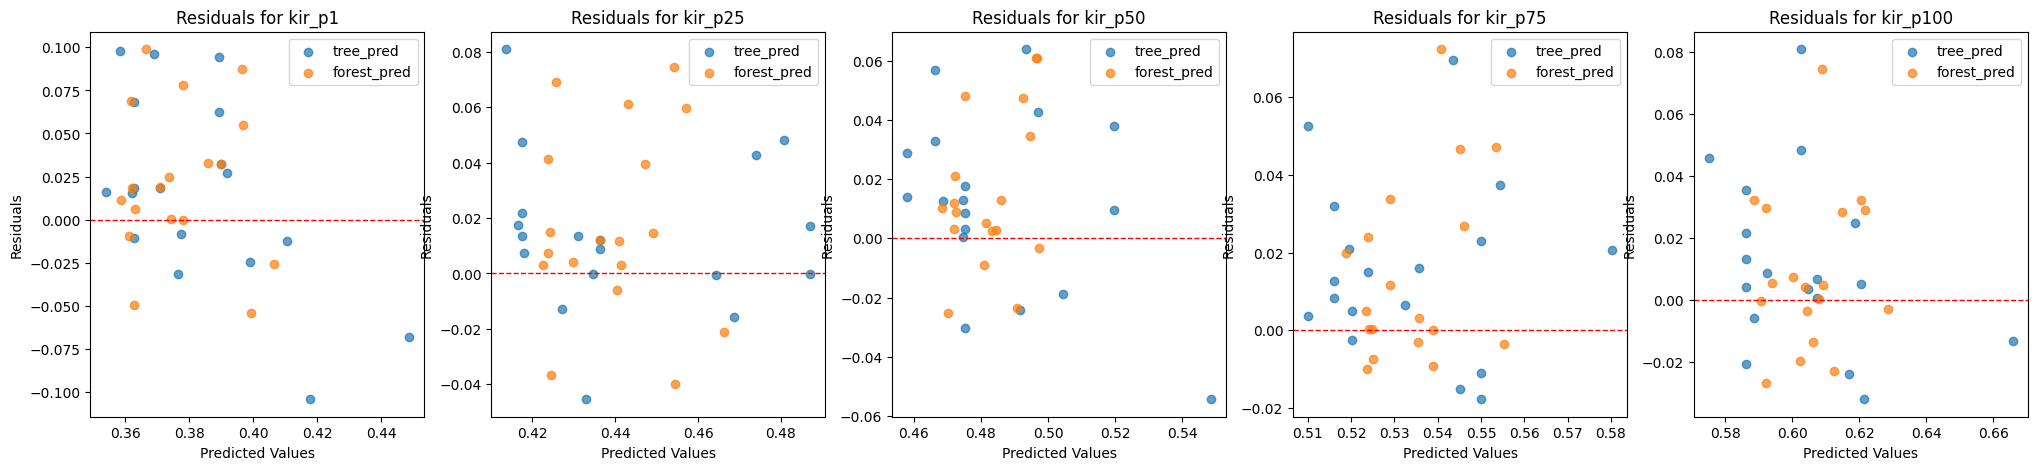

In [74]:
# Plot the residuals
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
axes = axes.flatten()

for i, data in enumerate(datasets):
    y_true = data.iloc[:, -3]
    tree_residuals = y_true - data["tree_pred"]
    forest_residuals = y_true - data["forest_pred"]
    axes[i].scatter(data["tree_pred"], tree_residuals, alpha=0.7, label="tree_pred")
    axes[i].scatter(data["forest_pred"], forest_residuals, alpha=0.7, label="forest_pred")
    axes[i].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[i].set_title(f"Residuals for {data.iloc[:, -3].name}")
    axes[i].set_xlabel("Predicted Values")
    axes[i].set_ylabel("Residuals")
    axes[i].legend(loc='upper right')

In [75]:
# Extract the data for each model
p1_data = pm25_trends.iloc[:, 1:11]
p1_data["pm2.5_mean"] = p1_data.mean(axis=1)
p1_data = pd.concat([p1_data, pm25_trends.iloc[:, 15]], axis=1)

p25_data = pm25_trends.iloc[:, 1:11]
p25_data["pm2.5_mean"] = p25_data.mean(axis=1)
p25_data = pd.concat([p25_data, pm25_trends.iloc[:, 16]], axis=1)

p50_data = pm25_trends.iloc[:, 1:11]
p50_data["pm2.5_mean"] = p50_data.mean(axis=1)
p50_data = pd.concat([p50_data, pm25_trends.iloc[:, 17]], axis=1)

p75_data = pm25_trends.iloc[:, 1:11]
p75_data["pm2.5_mean"] = p75_data.mean(axis=1)
p75_data = pd.concat([p75_data, pm25_trends.iloc[:, 18]], axis=1)

p100_data = pm25_trends.iloc[:, 1:11]
p100_data["pm2.5_mean"] = p100_data.mean(axis=1)
p100_data = pd.concat([p100_data, pm25_trends.iloc[:, 19]], axis=1)

# Split the data
p1_train, p1_test = train_test_split(p1_data, test_size=0.3, random_state=102)
p25_train, p25_test = train_test_split(p25_data, test_size=0.3, random_state=102)
p50_train, p50_test = train_test_split(p50_data, test_size=0.3, random_state=102)
p75_train, p75_test = train_test_split(p75_data, test_size=0.3, random_state=102)
p100_train, p100_test = train_test_split(p100_data, test_size=0.3, random_state=102)

# Train RandomForestRegressor models, and test them
p1_rf = RandomForestRegressor(max_features=2)
p1_rf.fit(p1_train.iloc[:, :-1], p1_train.iloc[:, -1])
p1_train["forest_pred_extra"] = p1_rf.predict(p1_train.iloc[:, :-1])
p1_test["forest_pred_extra"] = p1_rf.predict(p1_test.iloc[:, :-1])

p25_rf = RandomForestRegressor(max_features=2)
p25_rf.fit(p25_train.iloc[:, :-1], p25_train.iloc[:, -1])
p25_train["forest_pred_extra"] = p25_rf.predict(p25_train.iloc[:, :-1])
p25_test["forest_pred_extra"] = p25_rf.predict(p25_test.iloc[:, :-1])

p50_rf = RandomForestRegressor(max_features=2)
p50_rf.fit(p50_train.iloc[:, :-1], p50_train.iloc[:, -1])
p50_train["forest_pred_extra"] = p50_rf.predict(p50_train.iloc[:, :-1])
p50_test["forest_pred_extra"] = p50_rf.predict(p50_test.iloc[:, :-1])

p75_rf = RandomForestRegressor(max_features=2)
p75_rf.fit(p75_train.iloc[:, :-1], p75_train.iloc[:, -1])
p75_train["forest_pred_extra"] = p75_rf.predict(p75_train.iloc[:, :-1])
p75_test["forest_pred_extra"] = p75_rf.predict(p75_test.iloc[:, :-1])

p100_rf = RandomForestRegressor(max_features=2)
p100_rf.fit(p100_train.iloc[:, :-1], p100_train.iloc[:, -1])
p100_train["forest_pred_extra"] = p100_rf.predict(p100_train.iloc[:, :-1])
p100_test["forest_pred_extra"] = p100_rf.predict(p100_test.iloc[:, :-1])

In [76]:
# Get the train error
datasets = [p1_train, p25_train, p50_train, p75_train, p100_train]
for data in datasets:
  train_rmse = np.mean((data["forest_pred_extra"] - data.iloc[:, -2]) ** 2) ** 0.5
  print(f"Training set error for random forest, {data.iloc[:, -2].name}: ", train_rmse)

Training set error for random forest, kir_p1:  0.00933228870237252
Training set error for random forest, kir_p25:  0.008254073878254997
Training set error for random forest, kir_p50:  0.007479981759539389
Training set error for random forest, kir_p75:  0.007383513912442198
Training set error for random forest, kir_p100:  0.007596697640151145


In [77]:
# Get the test error
datasets = [p1_test, p25_test, p50_test, p75_test, p100_test]
for data in datasets:
  test_rmse = np.mean((data["forest_pred_extra"] - data.iloc[:, -2]) ** 2) ** 0.5
  results[f"Random forest w/ extra feature {data.iloc[:, -2].name}"] = test_rmse
  print(f"Test set error for random forest, {data.iloc[:, -2].name}: ", test_rmse)

Test set error for random forest, kir_p1:  0.04808619088227731
Test set error for random forest, kir_p25:  0.036504486979712626
Test set error for random forest, kir_p50:  0.030079136852236562
Test set error for random forest, kir_p75:  0.026845841275639548
Test set error for random forest, kir_p100:  0.025731899396447943


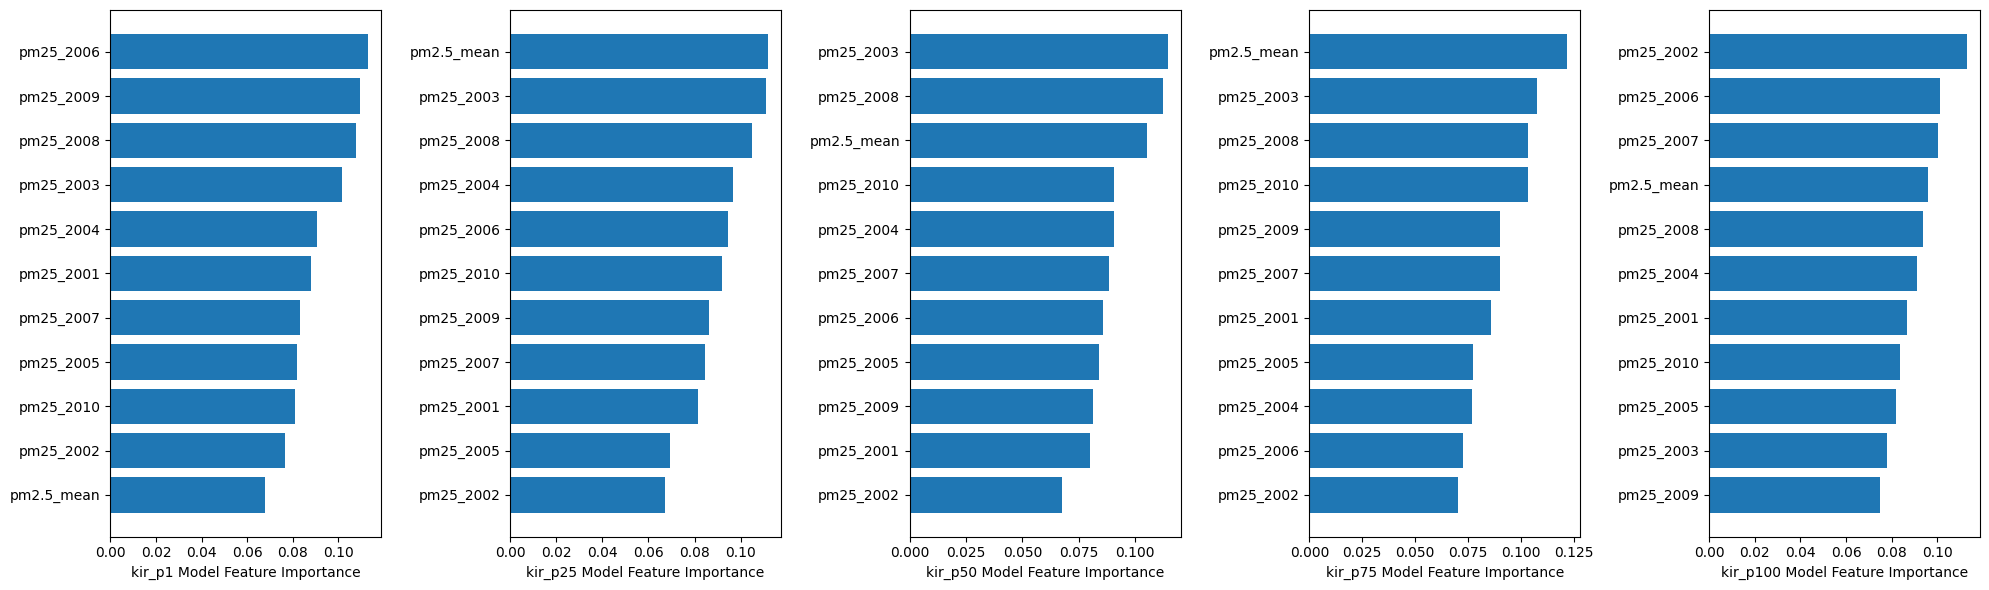

In [78]:
# Plot feature importance for each model
models = [p1_rf, p25_rf, p50_rf, p75_rf, p100_rf]
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

for i, (model, data) in enumerate(zip(models, datasets)):
    importances = model.feature_importances_
    sorted_idx = importances.argsort()
    feature_names = data.iloc[:, :-1].columns

    axes[i].barh(range(len(sorted_idx)), importances[sorted_idx], align="center")
    axes[i].set_yticks(range(len(sorted_idx)))
    axes[i].set_yticklabels(feature_names[sorted_idx])
    axes[i].set_xlabel(f"{data.iloc[:, -2].name} Model Feature Importance")

plt.tight_layout()
plt.show()

In [79]:
naive_estimator = pm25_trends.iloc[:, 15:]
naive_estimator = naive_estimator.mean(axis=1)

# Get the test error
datasets = [p1_test, p25_test, p50_test, p75_test, p100_test]
for i in range(len(datasets)):
  test_rmse = np.mean((naive_estimator.iloc[i] - datasets[i].iloc[:, -2]) ** 2) ** 0.5
  results[f"Naive Estimator {datasets[i].iloc[:, -2].name}"] = test_rmse
  print(f"Test set error for random forest, {datasets[i].iloc[:, -2].name}: ", test_rmse)

Test set error for random forest, kir_p1:  0.13908208219981874
Test set error for random forest, kir_p25:  0.058064662304326595
Test set error for random forest, kir_p50:  0.03856903154642741
Test set error for random forest, kir_p75:  0.05998012055537268
Test set error for random forest, kir_p100:  0.08771528024712463


In [80]:
for result in results:
  print(result, results[result])

Decisions tree kir_p1 0.056167795841261955
Decisions tree kir_p25 0.030862562333348144
Decisions tree kir_p50 0.031923604934936026
Decisions tree kir_p75 0.026775950589709444
Decisions tree kir_p100 0.029705947204635274
Random forest kir_p1 0.04773683830296426
Random forest kir_p25 0.03735874986606939
Random forest kir_p50 0.029304003039582017
Random forest kir_p75 0.026778756365573093
Random forest kir_p100 0.025943903660550775
Random forest w/ extra feature kir_p1 0.04808619088227731
Random forest w/ extra feature kir_p25 0.036504486979712626
Random forest w/ extra feature kir_p50 0.030079136852236562
Random forest w/ extra feature kir_p75 0.026845841275639548
Random forest w/ extra feature kir_p100 0.025731899396447943
Naive Estimator kir_p1 0.13908208219981874
Naive Estimator kir_p25 0.058064662304326595
Naive Estimator kir_p50 0.03856903154642741
Naive Estimator kir_p75 0.05998012055537268
Naive Estimator kir_p100 0.08771528024712463


In [81]:
# Perform cross-validation and collect the scores
p1_rf = RandomForestRegressor(max_features=2)
p1_scores = cross_val_score(p1_rf, p1_data.iloc[:, :-2], p1_data.iloc[:, -1], cv=5, scoring='neg_mean_squared_error')
p1_scores = np.sqrt(-p1_scores)

p25_rf = RandomForestRegressor(max_features=2)
p25_scores = cross_val_score(p25_rf, p25_data.iloc[:, :-2], p25_data.iloc[:, -1], cv=5, scoring='neg_mean_squared_error')
p25_scores = np.sqrt(-p25_scores)

p50_rf = RandomForestRegressor(max_features=2)
p50_scores = cross_val_score(p50_rf, p50_data.iloc[:, :-2], p50_data.iloc[:, -1], cv=5, scoring='neg_mean_squared_error')
p50_scores = np.sqrt(-p50_scores)

p75_rf = RandomForestRegressor(max_features=2)
p75_scores = cross_val_score(p75_rf, p75_data.iloc[:, :-2], p75_data.iloc[:, -1], cv=5, scoring='neg_mean_squared_error')
p75_scores = np.sqrt(-p75_scores)

p100_rf = RandomForestRegressor(max_features=2)
p100_scores = cross_val_score(p100_rf, p100_data.iloc[:, :-2], p100_data.iloc[:, -1], cv=5, scoring='neg_mean_squared_error')
p100_scores = np.sqrt(-p100_scores)

# Cross-validation results
print("Random Forest RMSE Scores")
print(np.mean(p1_scores))
print(np.mean(p25_scores))
print(np.mean(p50_scores))
print(np.mean(p75_scores))
print(np.mean(p100_scores))
scores = [np.mean(p1_scores), np.mean(p25_scores), np.mean(p50_scores), np.mean(p75_scores), np.mean(p100_scores)]
print("final score ", np.mean(scores))

Random Forest RMSE Scores
0.032127750062524024
0.026678691422885835
0.02306569072099137
0.022136329410008575
0.02382384172736258
final score  0.025566460668754475


### Results
Random forest performed the best for p1, p25, p50, and p100 models. Decision tree performed best on the p75 model. The difference between the two is less than 0.002. The RMSE of the best model is around 0.03+/-0.01 percentile points. The range of percentiles for each parental income at birth is approx. 0.1. Residuals showed a positive bias. Adding a cumulative feature did not add any improvement to performance. A naive estimator performed the worst suggesting that air quality does provide some useful information for predicting outcomes. More investigation is needed to obtain expressive features that could provide more predictive power. Based on the importance of features, there isn't a clear year that stands out across children of all socioeconomic backgrounds. Air quality had the strongest predictive power for the 100th percentile and the poorest predictive power for the 1st percentile of parental income.

## Parametric Prediction: GLMs

In [82]:
ca_air_quality = pd.read_csv('ca_air_quality.csv')
ca_trends = pd.read_csv('ca_trends.csv')

In [83]:
ca_air_quality.head()

,county,year,pm25_mean
0,Alameda County,2001,11.337368
1,Alameda County,2002,12.515194
2,Alameda County,2003,11.746714
3,Alameda County,2004,10.519771
4,Alameda County,2005,10.046940


In [84]:
ca_air_quality.shape

(812, 3)

In [85]:
ca_air_quality.columns

Index(['county', 'year', 'pm25_mean'], dtype='object')

In [86]:
ca_trends.head()

,county_name,kfr_p1,kfr_p25,kfr_p50,kfr_p75,kfr_p100,kir_p1,kir_p25,kir_p50,kir_p75,...,kfi_p1,kii_p1,kfi_p25,kii_p25,kfi_p50,kii_p50,kfi_p75,kii_p75,kfi_p100,kii_p100
0,Alameda,0.397131,0.454142,0.494372,0.560972,0.620201,0.423974,0.480677,0.519578,0.580212,...,26990.434,22839.928,31948.490,27306.277,35490.293,30319.748,41629.199,35054.789,47651.973,40606.148
1,Amador,0.421679,0.477740,0.521561,0.564419,0.607557,0.418718,0.463691,0.498969,0.539051,...,29123.459,22421.004,34014.910,25981.512,37944.645,28730.098,41957.102,31834.590,46296.137,35787.031
2,Butte,0.335972,0.420086,0.482973,0.551201,0.620764,0.340167,0.413760,0.468725,0.530784,...,21669.656,16051.436,28984.219,22025.777,34479.141,26376.275,40699.688,31191.508,47712.863,37937.078
3,Calaveras,0.412029,0.469688,0.514277,0.561053,0.607578,0.391870,0.448704,0.491574,0.540220,...,28283.742,20281.033,33307.535,24806.279,37280.715,28155.248,41636.918,31924.805,46298.473,36986.430
4,Colusa,0.441396,0.500426,0.537842,0.577317,0.625647,0.426208,0.487080,0.527387,0.571380,...,30834.238,23017.938,36034.262,27802.826,39438.016,30925.113,43221.762,34362.160,48242.590,40188.762


In [87]:
ca_trends.shape

(57, 26)

In [88]:
ca_trends.columns

Index(['county_name', 'kfr_p1', 'kfr_p25', 'kfr_p50', 'kfr_p75', 'kfr_p100',
       'kir_p1', 'kir_p25', 'kir_p50', 'kir_p75', 'kir_p100', 'emp_p1',
       'emp_p25', 'emp_p50', 'emp_p75', 'emp_p100', 'kfi_p1', 'kii_p1',
       'kfi_p25', 'kii_p25', 'kfi_p50', 'kii_p50', 'kfi_p75', 'kii_p75',
       'kfi_p100', 'kii_p100'],
      dtype='object')

In [89]:
ca_air_quality['county'] = ca_air_quality['county'].str.replace(' County', '', case = False).str.strip()
ca_air_quality

,county,year,pm25_mean
0,Alameda,2001,11.337368
1,Alameda,2002,12.515194
2,Alameda,2003,11.746714
3,Alameda,2004,10.519771
4,Alameda,2005,10.046940
...,...,...,...
807,Yuba,2010,6.952217
808,Yuba,2011,8.149655
809,Yuba,2012,7.294784
810,Yuba,2013,9.035700


In [90]:
air_quality_reshaped = ca_air_quality.pivot(index = 'county', columns = 'year', values = 'pm25_mean')
air_quality_reshaped.columns = [f"pm25_{year}" for year in air_quality_reshaped.columns]
air_quality_reshaped.reset_index(inplace = True)
air_quality_reshaped.head()

,county,pm25_2001,pm25_2002,pm25_2003,pm25_2004,pm25_2005,pm25_2006,pm25_2007,pm25_2008,pm25_2009,pm25_2010,pm25_2011,pm25_2012,pm25_2013,pm25_2014
0,Alameda,11.337368,12.515194,11.746714,10.519771,10.046940,10.537818,10.250983,12.302362,10.709889,9.295202,9.900472,8.244112,11.000615,8.970681
1,Alpine,7.686804,8.902171,8.080624,8.087348,7.934023,7.889818,5.296605,7.053058,6.361883,5.676465,6.121720,4.880946,6.543713,5.618063
2,Amador,10.403291,12.218641,11.029036,10.650562,10.286229,10.670561,8.739039,10.444600,8.417258,6.972696,7.685671,6.842723,8.366759,7.391469
3,Butte,10.039504,11.240247,10.582500,9.622950,9.575341,9.548045,8.434938,11.905424,8.135903,6.726448,7.720789,6.901922,8.653571,8.281286
4,Calaveras,10.343406,11.958018,11.248459,10.422676,10.063839,10.441275,8.278623,9.953259,8.239809,6.911949,7.490275,6.564585,8.256749,7.397673


In [91]:
income_data = ca_trends[[column for column in ca_trends.columns if 'kir' in column] + ['county_name']]
income_data.head()

,kir_p1,kir_p25,kir_p50,kir_p75,kir_p100,county_name
0,0.423974,0.480677,0.519578,0.580212,0.648633,Alameda
1,0.418718,0.463691,0.498969,0.539051,0.589476,Amador
2,0.340167,0.413760,0.468725,0.530784,0.616269,Butte
3,0.391870,0.448704,0.491574,0.540220,0.604524,Calaveras
4,0.426208,0.487080,0.527387,0.571380,0.643638,Colusa


In [92]:
df = pd.merge(air_quality_reshaped, income_data, left_on = 'county', right_on = 'county_name').drop(columns = ['county_name'])
df.head()

,county,pm25_2001,pm25_2002,pm25_2003,pm25_2004,pm25_2005,pm25_2006,pm25_2007,pm25_2008,pm25_2009,pm25_2010,pm25_2011,pm25_2012,pm25_2013,pm25_2014,kir_p1,kir_p25,kir_p50,kir_p75,kir_p100
0,Alameda,11.337368,12.515194,11.746714,10.519771,10.046940,10.537818,10.250983,12.302362,10.709889,9.295202,9.900472,8.244112,11.000615,8.970681,0.423974,0.480677,0.519578,0.580212,0.648633
1,Amador,10.403291,12.218641,11.029036,10.650562,10.286229,10.670561,8.739039,10.444600,8.417258,6.972696,7.685671,6.842723,8.366759,7.391469,0.418718,0.463691,0.498969,0.539051,0.589476
2,Butte,10.039504,11.240247,10.582500,9.622950,9.575341,9.548045,8.434938,11.905424,8.135903,6.726448,7.720789,6.901922,8.653571,8.281286,0.340167,0.413760,0.468725,0.530784,0.616269
3,Calaveras,10.343406,11.958018,11.248459,10.422676,10.063839,10.441275,8.278623,9.953259,8.239809,6.911949,7.490275,6.564585,8.256749,7.397673,0.391870,0.448704,0.491574,0.540220,0.604524
4,Colusa,9.920628,11.080532,10.758623,9.244025,9.036551,9.721230,7.110535,10.410877,7.106684,5.625827,6.696528,6.214777,7.193123,7.646409,0.426208,0.487080,0.527387,0.571380,0.643638


In [93]:
df1 = pd.concat([df.iloc[:, 1:15], df.iloc[:, 15]], axis = 1)
df25 = pd.concat([df.iloc[:, 1:15], df.iloc[:, 16]], axis = 1)
df50 = pd.concat([df.iloc[:, 1:15], df.iloc[:, 17]], axis = 1)
df75 = pd.concat([df.iloc[:, 1:15], df.iloc[:, 18]], axis = 1)
df100 = pd.concat([df.iloc[:, 1:15], df.iloc[:, 19]], axis = 1)

In [94]:
from sklearn.model_selection import train_test_split
df1_train, df1_test = train_test_split(df1, test_size = 0.25, random_state = 4)
df25_train, df25_test = train_test_split(df25, test_size = 0.25, random_state = 4)
df50_train, df50_test = train_test_split(df50, test_size = 0.25, random_state = 4)
df75_train, df75_test = train_test_split(df75, test_size = 0.25, random_state = 4)
df100_train, df100_test = train_test_split(df100, test_size = 0.25, random_state = 4)

#### Linear Regression

In [95]:
from sklearn.linear_model import LinearRegression

In [96]:
lm1 = LinearRegression().fit(df1_train.iloc[:, 0:14], df1_train.iloc[:, 14])

In [97]:
lm25 = LinearRegression().fit(df25_train.iloc[:, 0:14], df25_train.iloc[:, 14])

In [98]:
lm50 = LinearRegression().fit(df50_train.iloc[:, 0:14], df50_train.iloc[:, 14])

In [99]:
lm75 = LinearRegression().fit(df75_train.iloc[:, 0:14], df75_train.iloc[:, 14])

In [100]:
lm100 = LinearRegression().fit(df100_train.iloc[:, 0:14], df100_train.iloc[:, 14])

In [101]:
from sklearn.metrics import mean_squared_error

In [102]:
years = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']

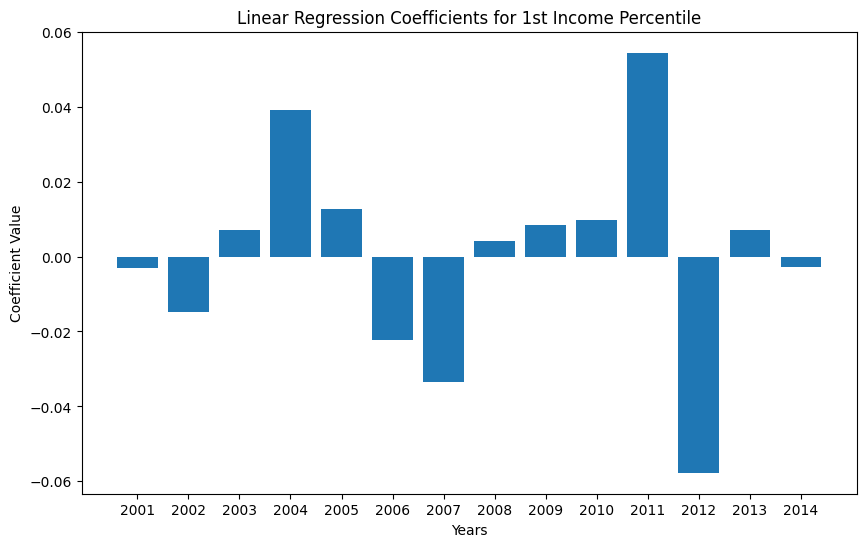

In [103]:
coef_1 = lm1.coef_
plt.figure(figsize = (10, 6))
plt.bar(years, coef_1)
plt.xlabel('Years')
plt.ylabel('Coefficient Value')
plt.title('Linear Regression Coefficients for 1st Income Percentile')
plt.show()

In [104]:
lm1_pred = lm1.predict(df1_test.iloc[:, 0:14])
lm1_rmse = np.sqrt(mean_squared_error(lm1_pred, df1_test.iloc[:, 14]))
lm1_rmse

0.04768269731794345

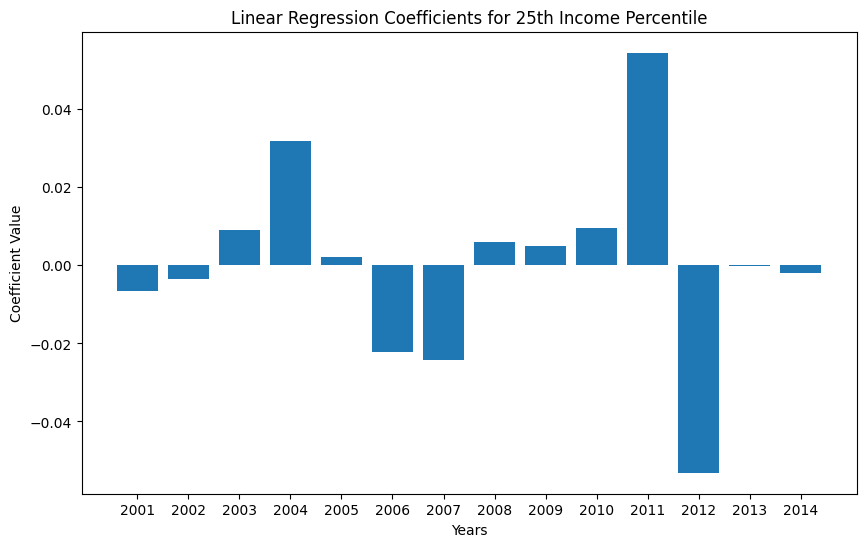

In [105]:
coef_25 = lm25.coef_
plt.figure(figsize = (10, 6))
plt.bar(years, coef_25)
plt.xlabel('Years')
plt.ylabel('Coefficient Value')
plt.title('Linear Regression Coefficients for 25th Income Percentile')
plt.show()

In [106]:
lm25_pred = lm25.predict(df25_test.iloc[:, 0:14])
lm25_rmse = np.sqrt(mean_squared_error(lm25_pred, df25_test.iloc[:, 14]))
lm25_rmse

0.041481375876220486

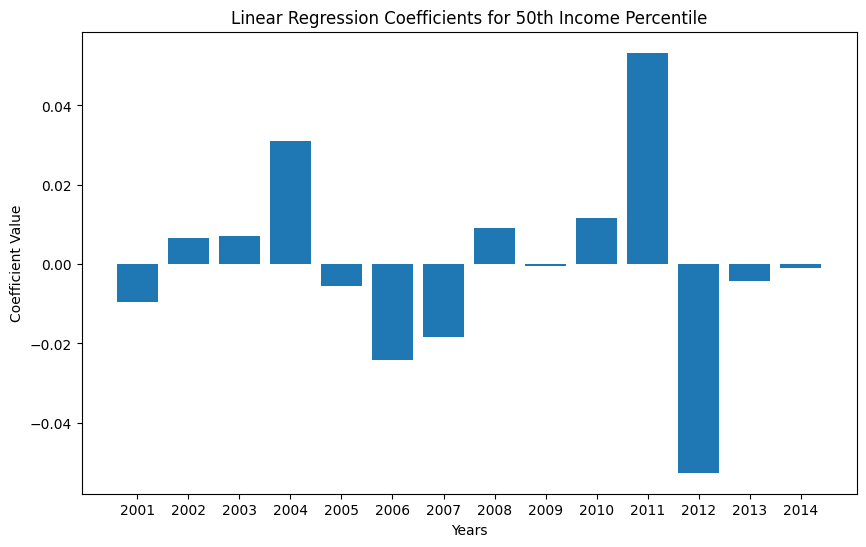

In [107]:
coef_50 = lm50.coef_
plt.figure(figsize = (10, 6))
plt.bar(years, coef_50)
plt.xlabel('Years')
plt.ylabel('Coefficient Value')
plt.title('Linear Regression Coefficients for 50th Income Percentile')
plt.show()

In [108]:
lm50_pred = lm50.predict(df50_test.iloc[:, 0:14])
lm50_rmse = np.sqrt(mean_squared_error(lm50_pred, df50_test.iloc[:, 14]))
lm50_rmse

0.036951964294285614

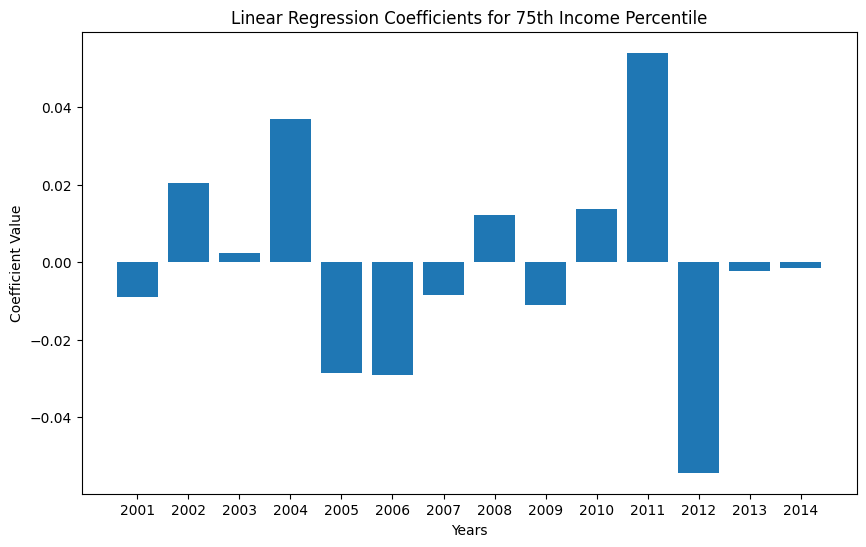

In [109]:
coef_75 = lm75.coef_
plt.figure(figsize = (10, 6))
plt.bar(years, coef_75)
plt.xlabel('Years')
plt.ylabel('Coefficient Value')
plt.title('Linear Regression Coefficients for 75th Income Percentile')
plt.show()

In [110]:
lm75_pred = lm75.predict(df75_test.iloc[:, 0:14])
lm75_rmse = np.sqrt(mean_squared_error(lm75_pred, df75_test.iloc[:, 14]))
lm75_rmse

0.03281401148283246

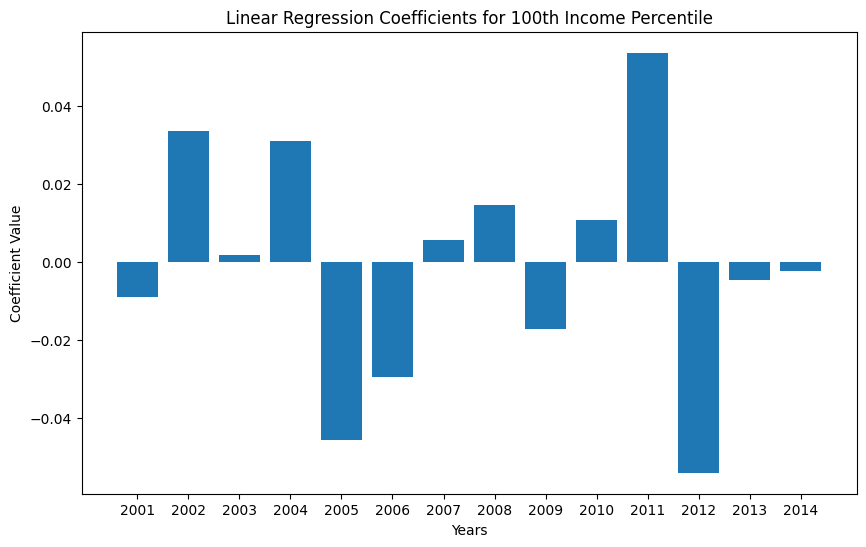

In [111]:
coef_100 = lm100.coef_
plt.figure(figsize = (10, 6))
plt.bar(years, coef_100)
plt.xlabel('Years')
plt.ylabel('Coefficient Value')
plt.title('Linear Regression Coefficients for 100th Income Percentile')
plt.show()

In [112]:
lm100_pred = lm100.predict(df100_test.iloc[:, 0:14])
lm100_rmse = np.sqrt(mean_squared_error(lm100_pred, df100_test.iloc[:, 14]))
lm100_rmse

0.03446436938218772

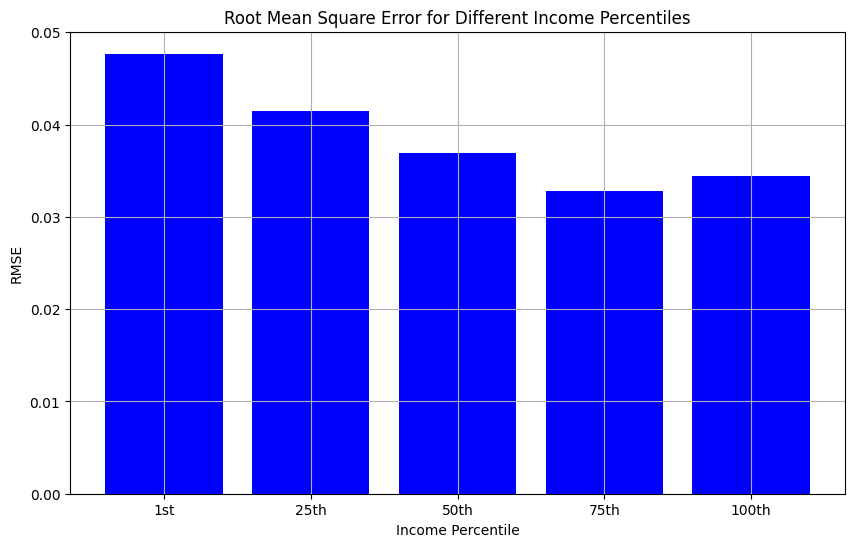

In [113]:
rmse_list = [lm1_rmse, lm25_rmse, lm50_rmse, lm75_rmse, lm100_rmse]
percentile_list = ['1st', '25th', '50th', '75th', '100th']
plt.figure(figsize = (10, 6))
plt.bar(percentile_list, rmse_list, color = 'blue')
plt.title('Root Mean Square Error for Different Income Percentiles')
plt.xlabel('Income Percentile')
plt.ylabel('RMSE')
plt.grid()
plt.show()

#### Gaussian Regression with StatsModels

In [114]:
glm1 = sm.GLM(df1.iloc[:, 14], exog = sm.add_constant(df1.iloc[:, 0:14]), family = sm.families.Gaussian())
glm1_res = glm1.fit()
print(glm1_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 kir_p1   No. Observations:                   57
Model:                            GLM   Df Residuals:                       42
Model Family:                Gaussian   Df Model:                           14
Link Function:               Identity   Scale:                      0.00083215
Method:                          IRLS   Log-Likelihood:                 129.93
Date:                Mon, 16 Dec 2024   Deviance:                     0.034950
Time:                        19:52:04   Pearson chi2:                   0.0350
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5397
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3966      0.090      4.421      0.0

In [115]:
glm25 = sm.GLM(df25.iloc[:, 14], exog = sm.add_constant(df25.iloc[:, 0:14]), family = sm.families.Gaussian())
glm25_res = glm25.fit()
print(glm25_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                kir_p25   No. Observations:                   57
Model:                            GLM   Df Residuals:                       42
Model Family:                Gaussian   Df Model:                           14
Link Function:               Identity   Scale:                      0.00059122
Method:                          IRLS   Log-Likelihood:                 139.67
Date:                Mon, 16 Dec 2024   Deviance:                     0.024831
Time:                        19:52:05   Pearson chi2:                   0.0248
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5260
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4372      0.076      5.782      0.0

In [116]:
glm50 = sm.GLM(df50.iloc[:, 14], exog = sm.add_constant(df50.iloc[:, 0:14]), family = sm.families.Gaussian())
glm50_res = glm50.fit()
print(glm50_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                kir_p50   No. Observations:                   57
Model:                            GLM   Df Residuals:                       42
Model Family:                Gaussian   Df Model:                           14
Link Function:               Identity   Scale:                      0.00045518
Method:                          IRLS   Log-Likelihood:                 147.13
Date:                Mon, 16 Dec 2024   Deviance:                     0.019117
Time:                        19:52:05   Pearson chi2:                   0.0191
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4989
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4766      0.066      7.184      0.0

In [117]:
glm75 = sm.GLM(df75.iloc[:, 14], exog = sm.add_constant(df75.iloc[:, 0:14]), family = sm.families.Gaussian())
glm75_res = glm75.fit()
print(glm75_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                kir_p75   No. Observations:                   57
Model:                            GLM   Df Residuals:                       42
Model Family:                Gaussian   Df Model:                           14
Link Function:               Identity   Scale:                      0.00039853
Method:                          IRLS   Log-Likelihood:                 150.91
Date:                Mon, 16 Dec 2024   Deviance:                     0.016738
Time:                        19:52:05   Pearson chi2:                   0.0167
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5294
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5353      0.062      8.622      0.0

In [118]:
glm100 = sm.GLM(df100.iloc[:, 14], exog = sm.add_constant(df100.iloc[:, 0:14]), family = sm.families.Gaussian())
glm100_res = glm100.fit()
print(glm100_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               kir_p100   No. Observations:                   57
Model:                            GLM   Df Residuals:                       42
Model Family:                Gaussian   Df Model:                           14
Link Function:               Identity   Scale:                      0.00048027
Method:                          IRLS   Log-Likelihood:                 145.60
Date:                Mon, 16 Dec 2024   Deviance:                     0.020171
Time:                        19:52:05   Pearson chi2:                   0.0202
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4368
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6022      0.068      8.836      0.0

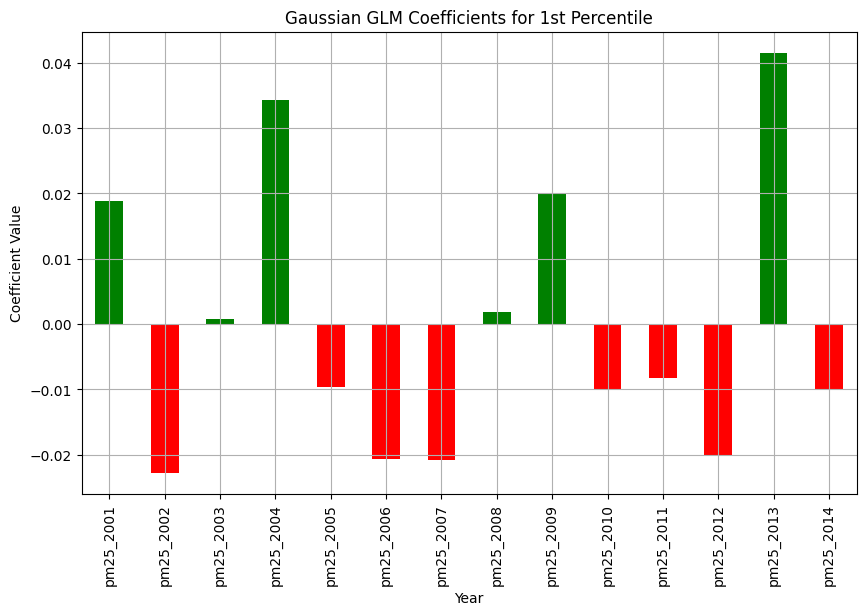

In [119]:
glm1_coef = glm1_res.params.drop('const')
plt.figure(figsize = (10, 6))
glm1_coef.plot(kind = 'bar', color = (glm1_coef > 0).map({True: 'green', False: 'red'}))
plt.title('Gaussian GLM Coefficients for 1st Percentile')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.grid()
plt.show()

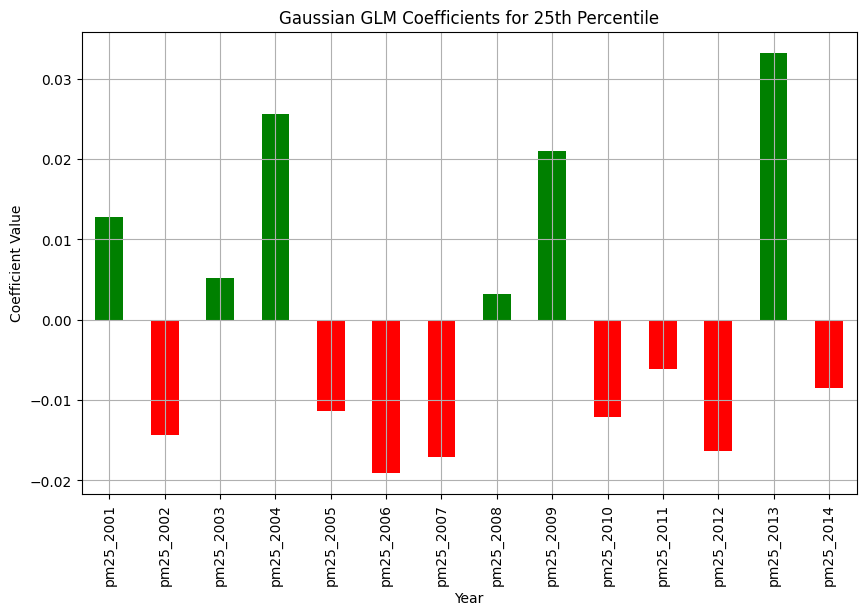

In [120]:
glm25_coef = glm25_res.params.drop('const')
plt.figure(figsize = (10, 6))
glm25_coef.plot(kind = 'bar', color = (glm25_coef > 0).map({True: 'green', False: 'red'}))
plt.title('Gaussian GLM Coefficients for 25th Percentile')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.grid()
plt.show()

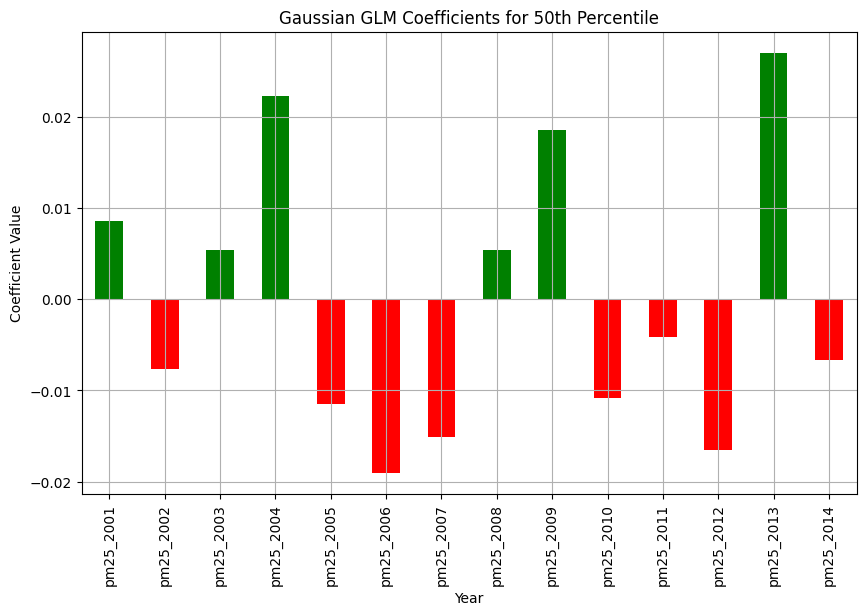

In [121]:
glm50_coef = glm50_res.params.drop('const')
plt.figure(figsize = (10, 6))
glm50_coef.plot(kind = 'bar', color = (glm50_coef > 0).map({True: 'green', False: 'red'}))
plt.title('Gaussian GLM Coefficients for 50th Percentile')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.grid()
plt.show()

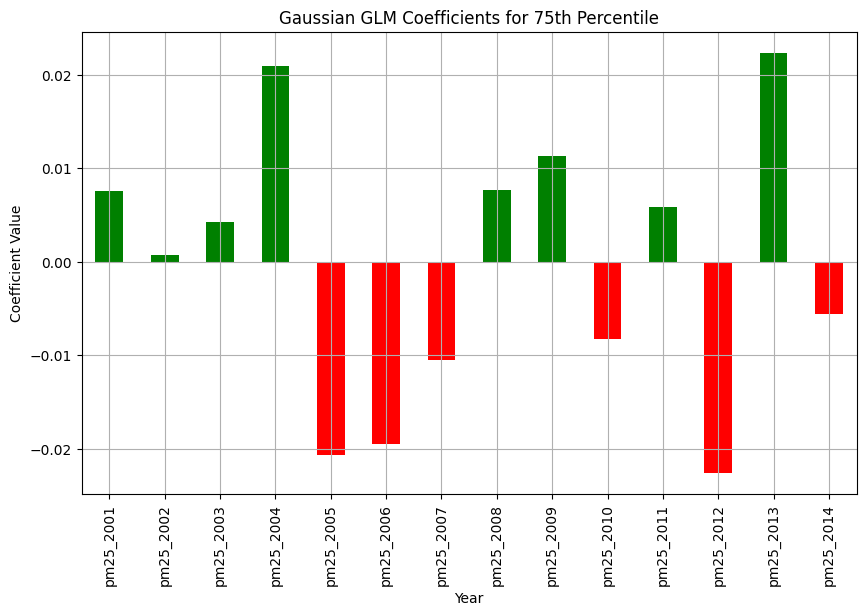

In [122]:
glm75_coef = glm75_res.params.drop('const')
plt.figure(figsize = (10, 6))
glm75_coef.plot(kind = 'bar', color = (glm75_coef > 0).map({True: 'green', False: 'red'}))
plt.title('Gaussian GLM Coefficients for 75th Percentile')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.grid()
plt.show()

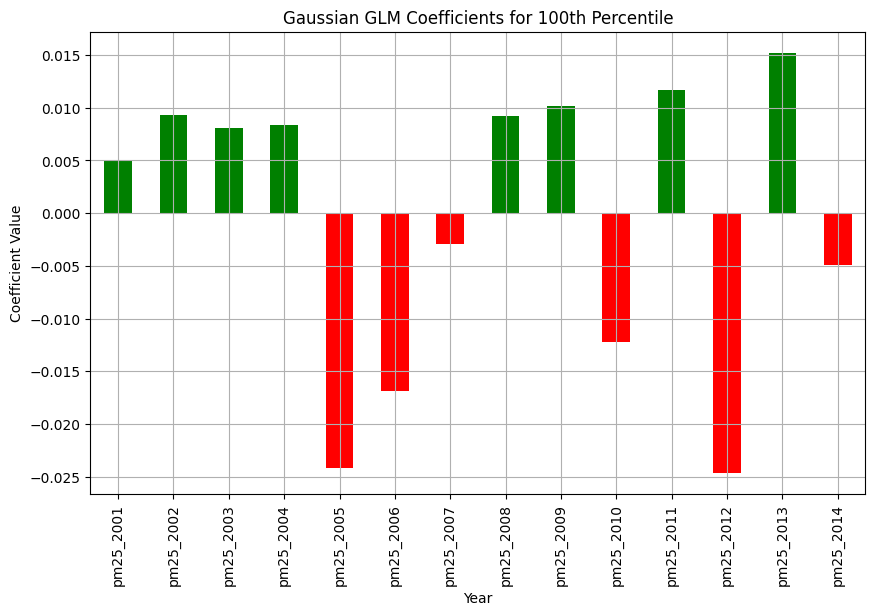

In [123]:
glm100_coef = glm100_res.params.drop('const')
plt.figure(figsize = (10, 6))
glm100_coef.plot(kind = 'bar', color = (glm100_coef > 0).map({True: 'green', False: 'red'}))
plt.title('Gaussian GLM Coefficients for 100th Percentile')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.grid()
plt.show()

#### Gamma Regression

In [124]:
gglm1 = sm.GLM(df1.iloc[:, 14], exog = sm.add_constant(df1.iloc[:, 0:14]), family = sm.families.Gamma())
gglm1_res = gglm1.fit()
print(gglm1_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 kir_p1   No. Observations:                   57
Model:                            GLM   Df Residuals:                       42
Model Family:                   Gamma   Df Model:                           14
Link Function:           InversePower   Scale:                       0.0053417
Method:                          IRLS   Log-Likelihood:                 130.23
Date:                Mon, 16 Dec 2024   Deviance:                      0.22439
Time:                        19:52:07   Pearson chi2:                    0.224
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5318
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5609      0.603      4.247      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [125]:
gglm25 = sm.GLM(df25.iloc[:, 14], exog = sm.add_constant(df25.iloc[:, 0:14]), family = sm.families.Gamma())
gglm25_res = gglm25.fit()
print(gglm25_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                kir_p25   No. Observations:                   57
Model:                            GLM   Df Residuals:                       42
Model Family:                   Gamma   Df Model:                           14
Link Function:           InversePower   Scale:                       0.0028687
Method:                          IRLS   Log-Likelihood:                 139.56
Date:                Mon, 16 Dec 2024   Deviance:                      0.11984
Time:                        19:52:07   Pearson chi2:                    0.120
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5099
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3017      0.379      6.071      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [126]:
gglm50 = sm.GLM(df50.iloc[:, 14], exog = sm.add_constant(df50.iloc[:, 0:14]), family = sm.families.Gamma())
gglm50_res = gglm50.fit()
print(gglm50_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                kir_p50   No. Observations:                   57
Model:                            GLM   Df Residuals:                       42
Model Family:                   Gamma   Df Model:                           14
Link Function:           InversePower   Scale:                       0.0018454
Method:                          IRLS   Log-Likelihood:                 146.95
Date:                Mon, 16 Dec 2024   Deviance:                     0.076890
Time:                        19:52:07   Pearson chi2:                   0.0775
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4798
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1038      0.277      7.608      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [127]:
gglm75 = sm.GLM(df75.iloc[:, 14], exog = sm.add_constant(df75.iloc[:, 0:14]), family = sm.families.Gamma())
gglm75_res = gglm75.fit()
print(gglm75_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                kir_p75   No. Observations:                   57
Model:                            GLM   Df Residuals:                       42
Model Family:                   Gamma   Df Model:                           14
Link Function:           InversePower   Scale:                       0.0013308
Method:                          IRLS   Log-Likelihood:                 150.52
Date:                Mon, 16 Dec 2024   Deviance:                     0.055558
Time:                        19:52:07   Pearson chi2:                   0.0559
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5076
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8719      0.212      8.835      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [128]:
gglm100 = sm.GLM(df100.iloc[:, 14], exog = sm.add_constant(df100.iloc[:, 0:14]), family = sm.families.Gamma())
gglm100_res = gglm100.fit()
print(gglm100_res.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


                 Generalized Linear Model Regression Results                  
Dep. Variable:               kir_p100   No. Observations:                   57
Model:                            GLM   Df Residuals:                       42
Model Family:                   Gamma   Df Model:                           14
Link Function:           InversePower   Scale:                       0.0012733
Method:                          IRLS   Log-Likelihood:                 144.75
Date:                Mon, 16 Dec 2024   Deviance:                     0.053332
Time:                        19:52:07   Pearson chi2:                   0.0535
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4095
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6630      0.183      9.088      0.0

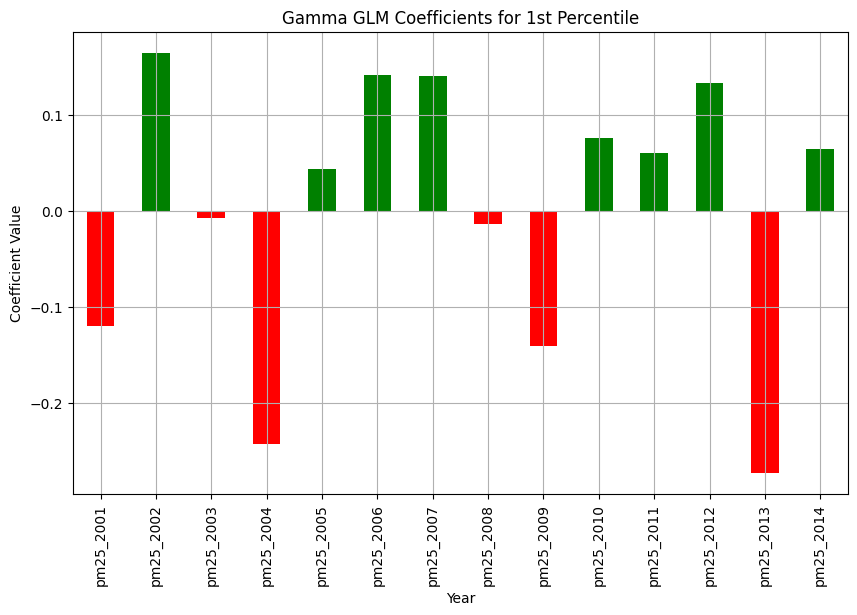

In [129]:
gglm1_coef = gglm1_res.params.drop('const')
plt.figure(figsize = (10, 6))
gglm1_coef.plot(kind = 'bar', color = (gglm1_coef > 0).map({True: 'green', False: 'red'}))
plt.title('Gamma GLM Coefficients for 1st Percentile')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.grid()
plt.show()

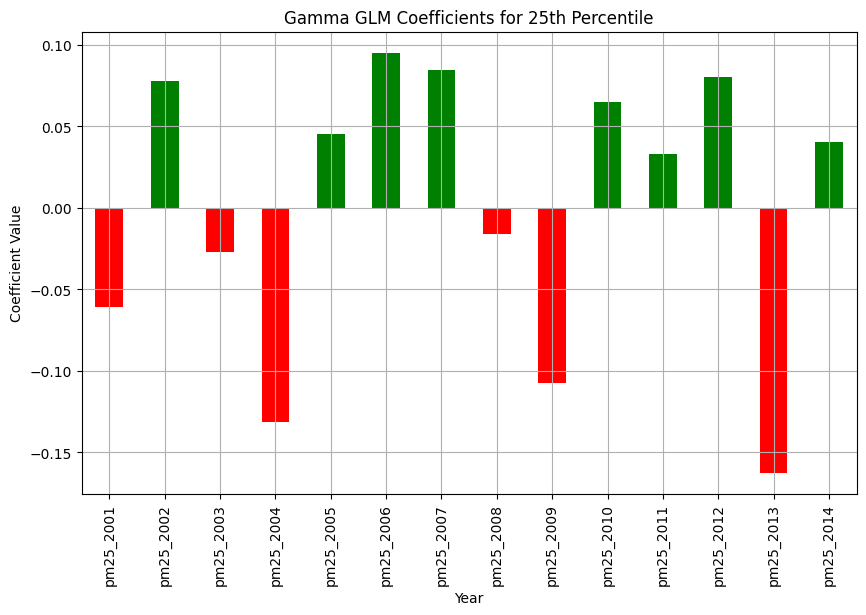

In [130]:
gglm25_coef = gglm25_res.params.drop('const')
plt.figure(figsize = (10, 6))
gglm25_coef.plot(kind = 'bar', color = (gglm25_coef > 0).map({True: 'green', False: 'red'}))
plt.title('Gamma GLM Coefficients for 25th Percentile')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.grid()
plt.show()

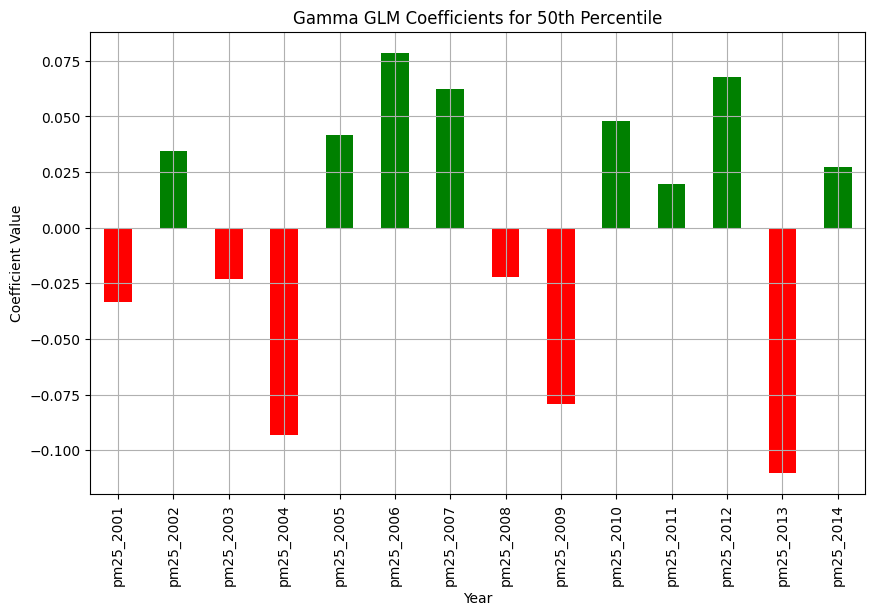

In [131]:
gglm50_coef = gglm50_res.params.drop('const')
plt.figure(figsize = (10, 6))
gglm50_coef.plot(kind = 'bar', color = (gglm50_coef > 0).map({True: 'green', False: 'red'}))
plt.title('Gamma GLM Coefficients for 50th Percentile')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.grid()
plt.show()

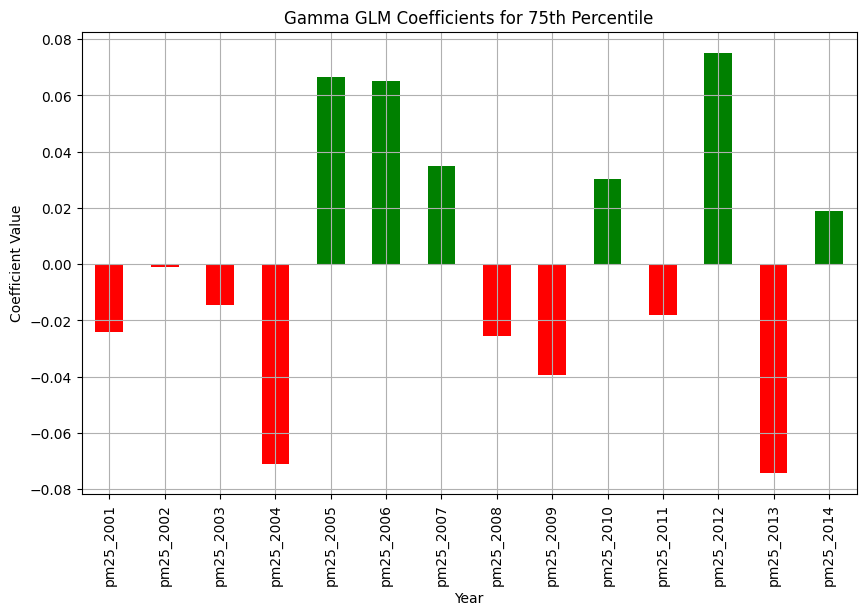

In [132]:
gglm75_coef = gglm75_res.params.drop('const')
plt.figure(figsize = (10, 6))
gglm75_coef.plot(kind = 'bar', color = (gglm75_coef > 0).map({True: 'green', False: 'red'}))
plt.title('Gamma GLM Coefficients for 75th Percentile')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.grid()
plt.show()

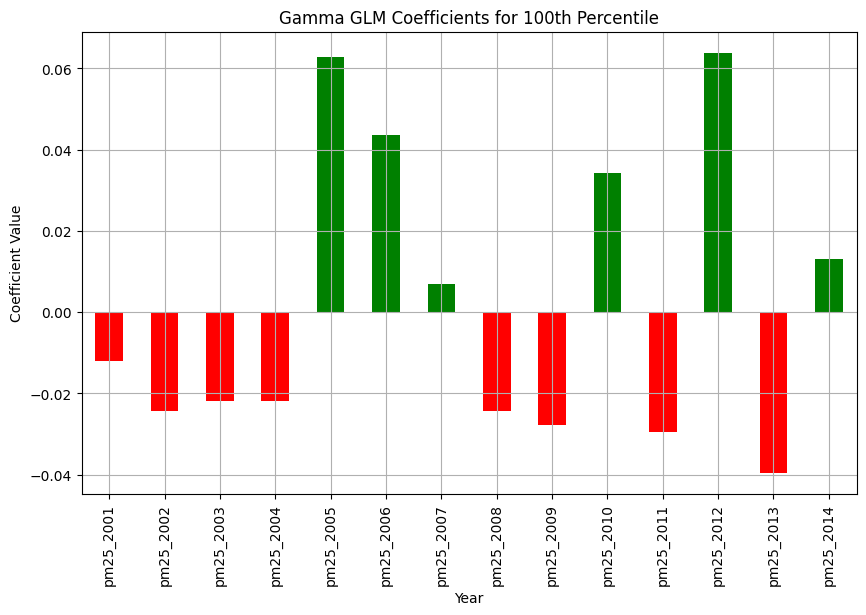

In [133]:
gglm100_coef = gglm100_res.params.drop('const')
plt.figure(figsize = (10, 6))
gglm100_coef.plot(kind = 'bar', color = (gglm100_coef > 0).map({True: 'green', False: 'red'}))
plt.title('Gamma GLM Coefficients for 100th Percentile')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.grid()
plt.show()

#### Results

Using a GLM to understand the relationship between air quality and income percentile reveals that air quality in different years has varying effects on the income percentile across all California counties. Looking into environment related legislation in the state for those years explains some of those trends.